In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import pickle

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier

import seaborn as sns
sns.set(style='darkgrid')
colors = ['#EE5622', '#FCBD51', '#836EA3', '#B1ACB8', '#D9CDEC', '#6E23C9', '#EF7A7A', '#EFBFA0']# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#path = '/content/drive/MyDrive/Kaggle/archive'

In [15]:
path = "D:\Work_dir\Master_work\Data\Bank_Account_Fraud_Dataset_Suite"

In [16]:
df = pd.read_csv(f'{path}/Base.csv')

In [17]:
df.shape

(1000000, 32)

In [18]:
df.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -1.331345           AA           769  ...                0   
1               -0.816224           AB           366  ...                0   
2               -0.755728           AC           870  ...                0   
3               -1.205124           AB           810  ...                1   
4               -0.773276           AB           890  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                 1500.0                0  INTERNET   

   session_length_in_minutes  device_os  keep_alive_session  \
0                   3.888115    windows                   0   
1                  31.798819    windows                   0   
2                   4.728705      other                   0   
3                   2.047904      linux                   0   
4                   3.775225  macintosh                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      7  
1                          1                  0      7  
2                          1                  0      7  
3                          1                  0      7  
4                          1                  0      7  

[5 rows x 32 columns]

# Набор данных о мошенничестве с банковскими счетами (NeurIPS 2022)

https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022?resource=download

## <span style='background-color: #87CEEB'> 1) Основные характеристики данных </span>

In [19]:
# Размеры таблицы
df.shape

(1000000, 32)

In [20]:
df.fraud_bool.value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

## <span style='background-color: #87CEEB'> 2) Описательные статистики </span>


In [21]:
df.describe(include='all')

fraud_bool          income  name_email_similarity  \
count   1000000.000000  1000000.000000         1000000.000000   
unique             NaN             NaN                    NaN   
top                NaN             NaN                    NaN   
freq               NaN             NaN                    NaN   
mean          0.011029        0.562696               0.493694   
std           0.104438        0.290343               0.289125   
min           0.000000        0.100000               0.000001   
25%           0.000000        0.300000               0.225216   
50%           0.000000        0.600000               0.492153   
75%           0.000000        0.800000               0.755567   
max           1.000000        0.900000               0.999999   

        prev_address_months_count  current_address_months_count  \
count              1000000.000000                1000000.000000   
unique                        NaN                           NaN   
top                           NaN                           NaN   
freq                          NaN                           NaN   
mean                    16.718568                     86.587867   
std                     44.046230                     88.406599   
min                     -1.000000                     -1.000000   
25%                     -1.000000                     19.000000   
50%                     -1.000000                     52.000000   
75%                     12.000000                    130.000000   
max                    383.000000                    428.000000   

          customer_age  days_since_request  intended_balcon_amount  \
count   1000000.000000        1.000000e+06          1000000.000000   
unique             NaN                 NaN                     NaN   
top                NaN                 NaN                     NaN   
freq               NaN                 NaN                     NaN   
mean         33.689080        1.025705e+00                8.661499   
std          12.025799        5.381835e+00               20.236155   
min          10.000000        4.036860e-09              -15.530555   
25%          20.000000        7.193246e-03               -1.181488   
50%          30.000000        1.517574e-02               -0.830507   
75%          40.000000        2.633069e-02                4.984176   
max          90.000000        7.845690e+01              112.956928   

       payment_type    zip_count_4w  ...  has_other_cards  \
count       1000000  1000000.000000  ...   1000000.000000   
unique            5             NaN  ...              NaN   
top              AB             NaN  ...              NaN   
freq         370554             NaN  ...              NaN   
mean            NaN     1572.692049  ...         0.222988   
std             NaN     1005.374565  ...         0.416251   
min             NaN        1.000000  ...         0.000000   
25%             NaN      894.000000  ...         0.000000   
50%             NaN     1263.000000  ...         0.000000   
75%             NaN     1944.000000  ...         0.000000   
max             NaN     6700.000000  ...         1.000000   

        proposed_credit_limit  foreign_request    source  \
count          1000000.000000   1000000.000000   1000000   
unique                    NaN              NaN         2   
top                       NaN              NaN  INTERNET   
freq                      NaN              NaN    992952   
mean               515.851010         0.025242       NaN   
std                487.559902         0.156859       NaN   
min                190.000000         0.000000       NaN   
25%                200.000000         0.000000       NaN   
50%                200.000000         0.000000       NaN   
75%                500.000000         0.000000       NaN   
max               2100.000000         1.000000       NaN   

        session_length_in_minutes device_os  keep_alive_session  \
count              1000000.000000   1000000      1000000.000000 

In [22]:
df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

Выводы:
- По описательным статистикам 5 категориальных признаков

## <span style='background-color: #87CEEB'> 3) Проверка пропусков </span>

In [23]:
df.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

Выводы:
- Пропусков в данных нет

## <span style='background-color: #87CEEB'>4) Числовые переменные </span>

In [24]:
object_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
object_cols

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [25]:
num_cols = df.dtypes[df.dtypes != 'object'].index.tolist()
num_cols

['fraud_bool',
 'income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

In [26]:
len(num_cols)

27

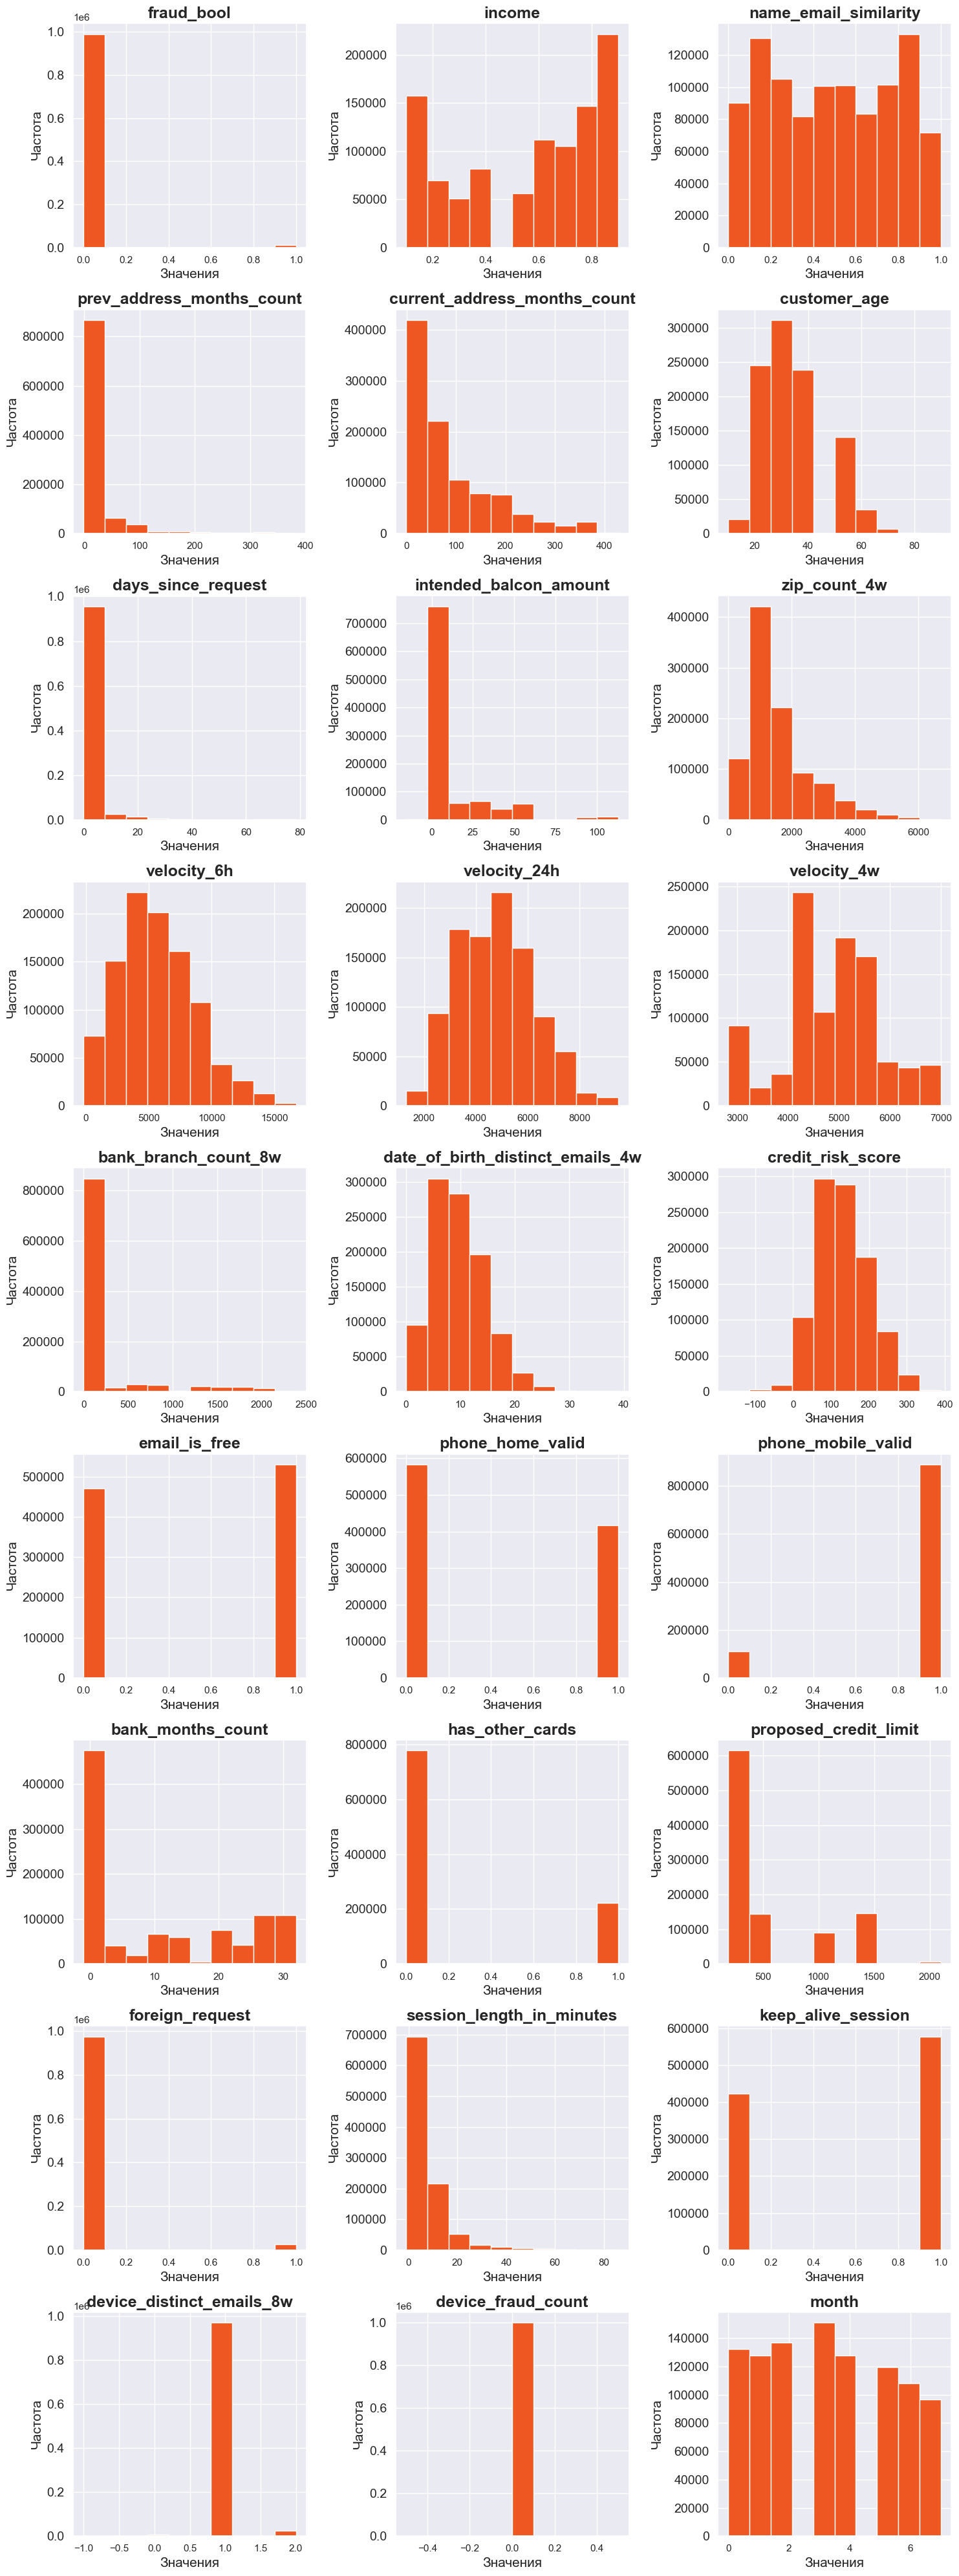

In [27]:
fig, axs = plt.subplots(9, 3, figsize=(15, 40))
for i, ax in enumerate(axs.flat):
    ax.hist(df[num_cols].iloc[:, i])
    ax.set_title(num_cols[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    fig.tight_layout()
None

### На основе графиков добавим в категориальные переменные некоторые столбцы

In [28]:
new_num = ['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_fraud_count',
 'month']

In [29]:
len(new_num)

19

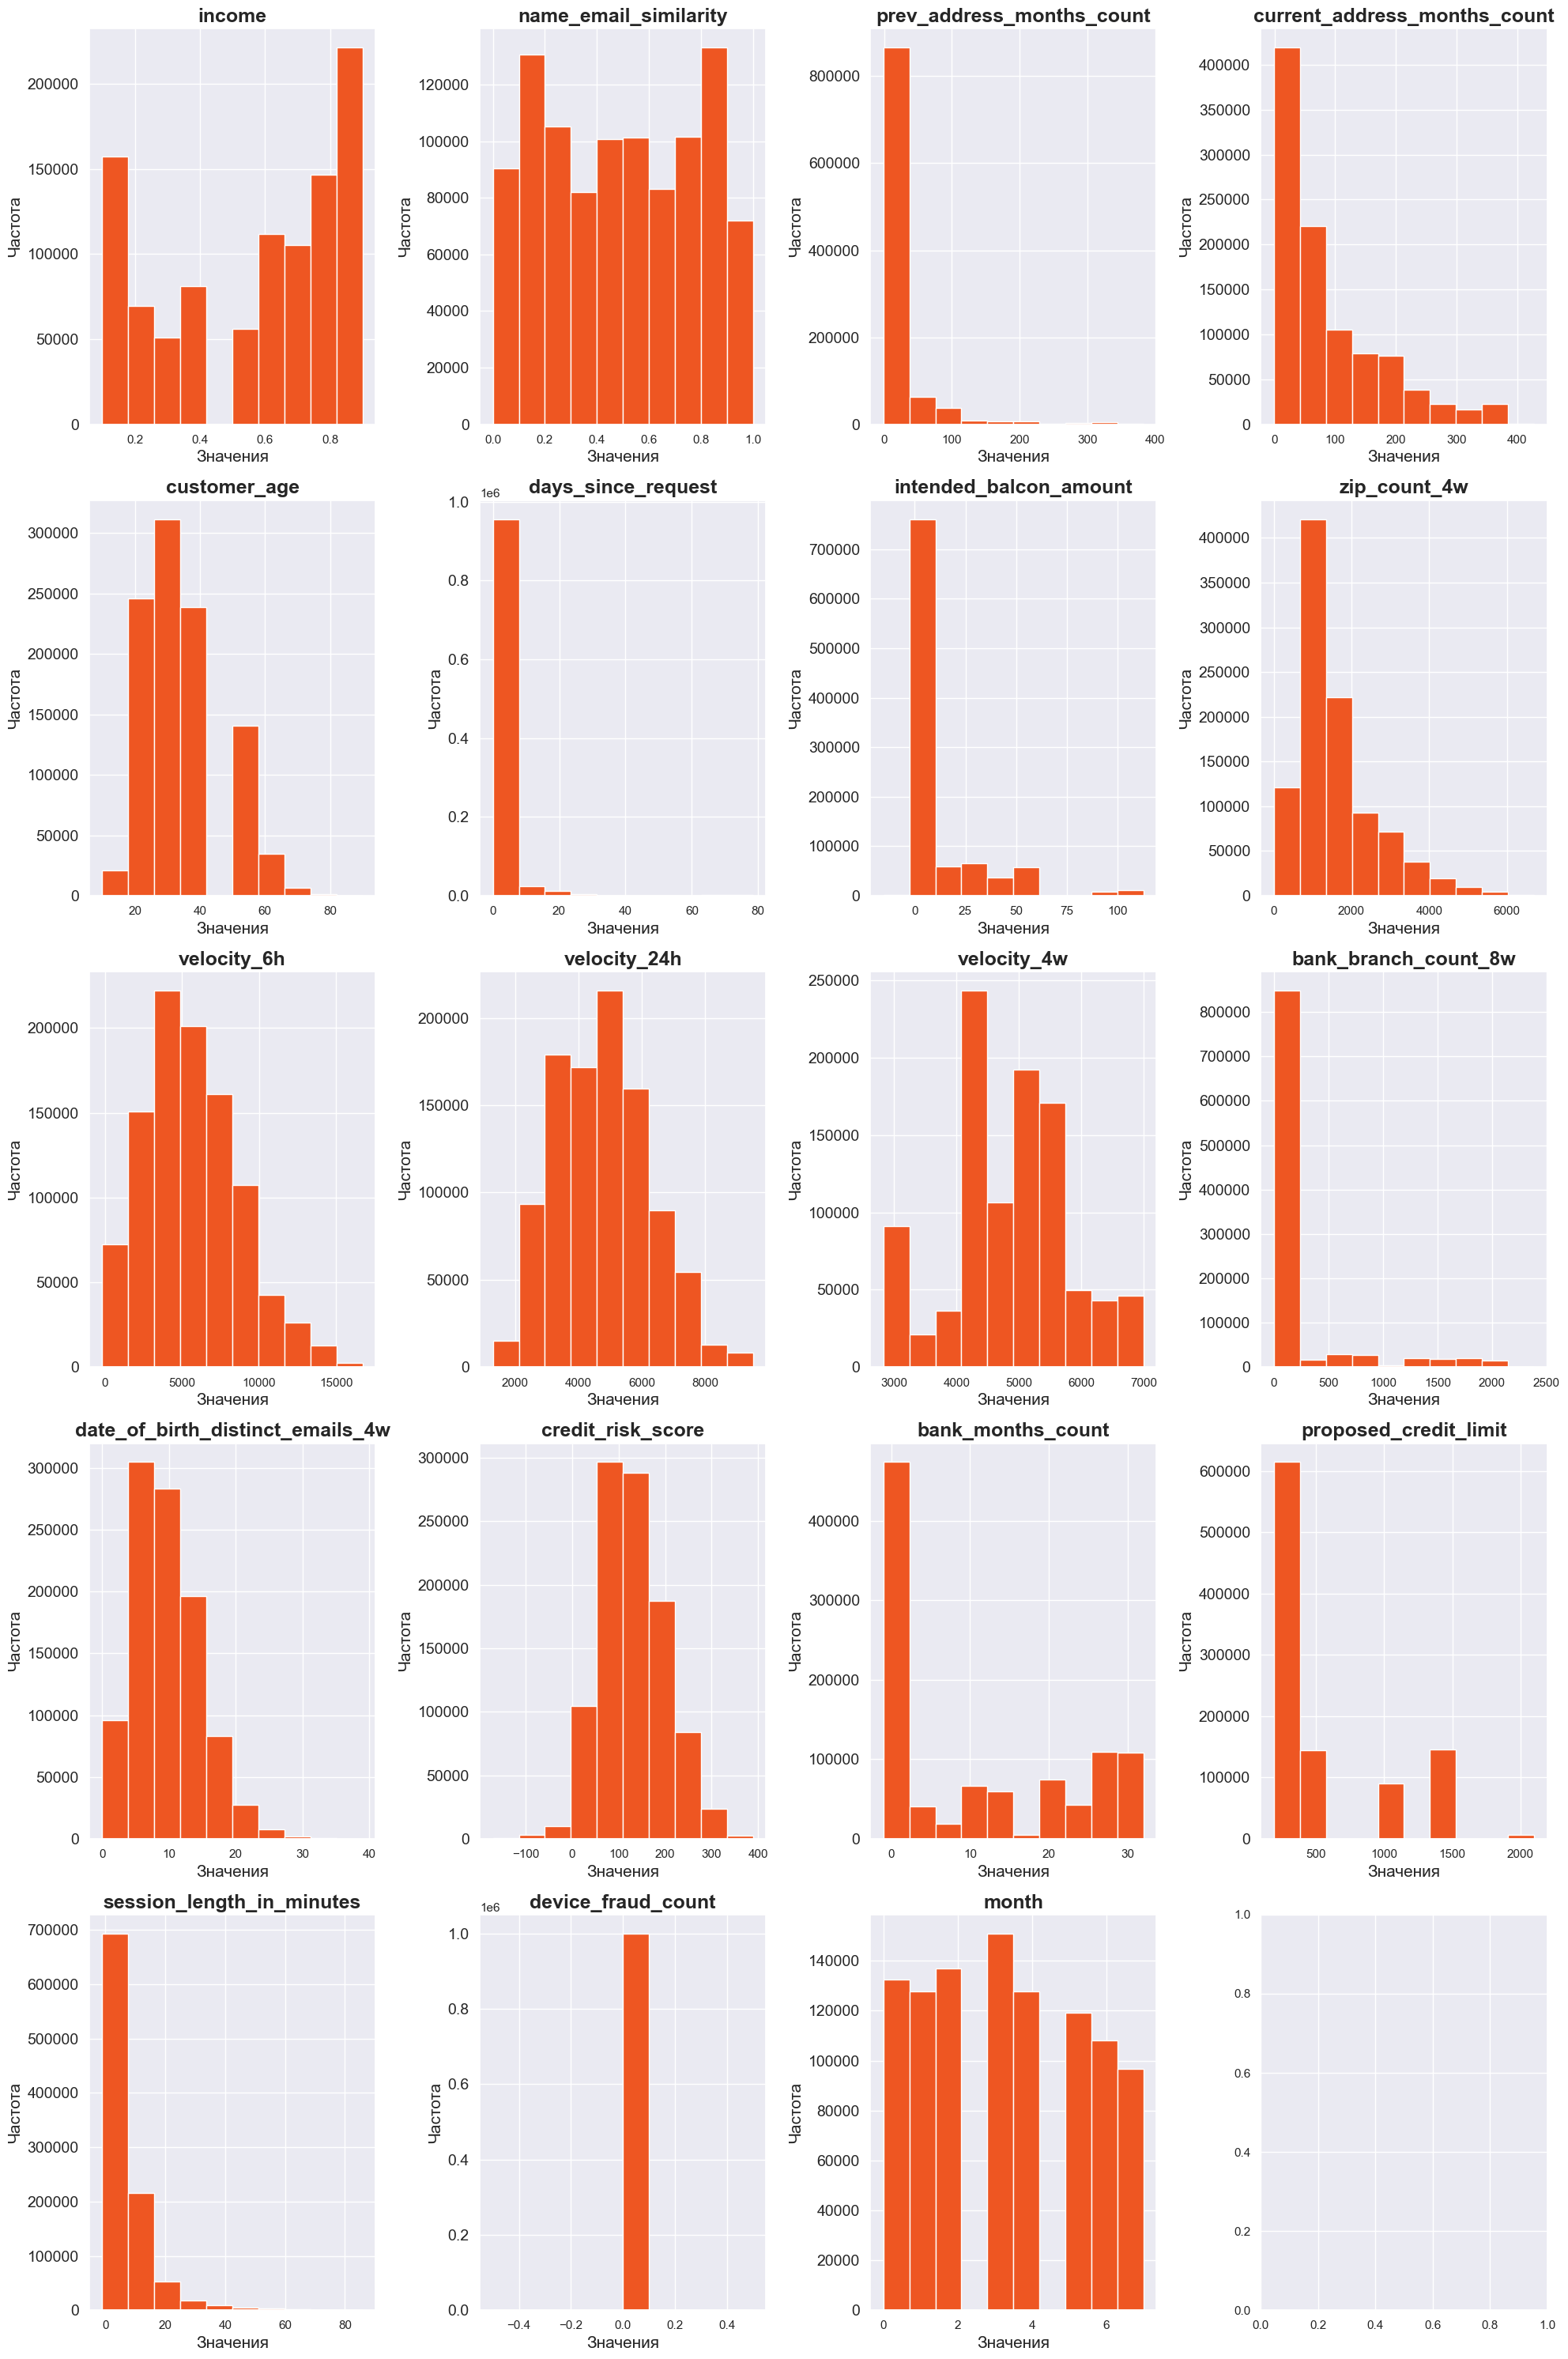

In [30]:
fig, axs = plt.subplots(5, 4, figsize=(20, 30))
for i, ax in enumerate(axs.flat):
    if i == 19:
        break
    ax.hist(df[new_num].iloc[:, i])
    ax.set_title(new_num[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    fig.tight_layout()
None

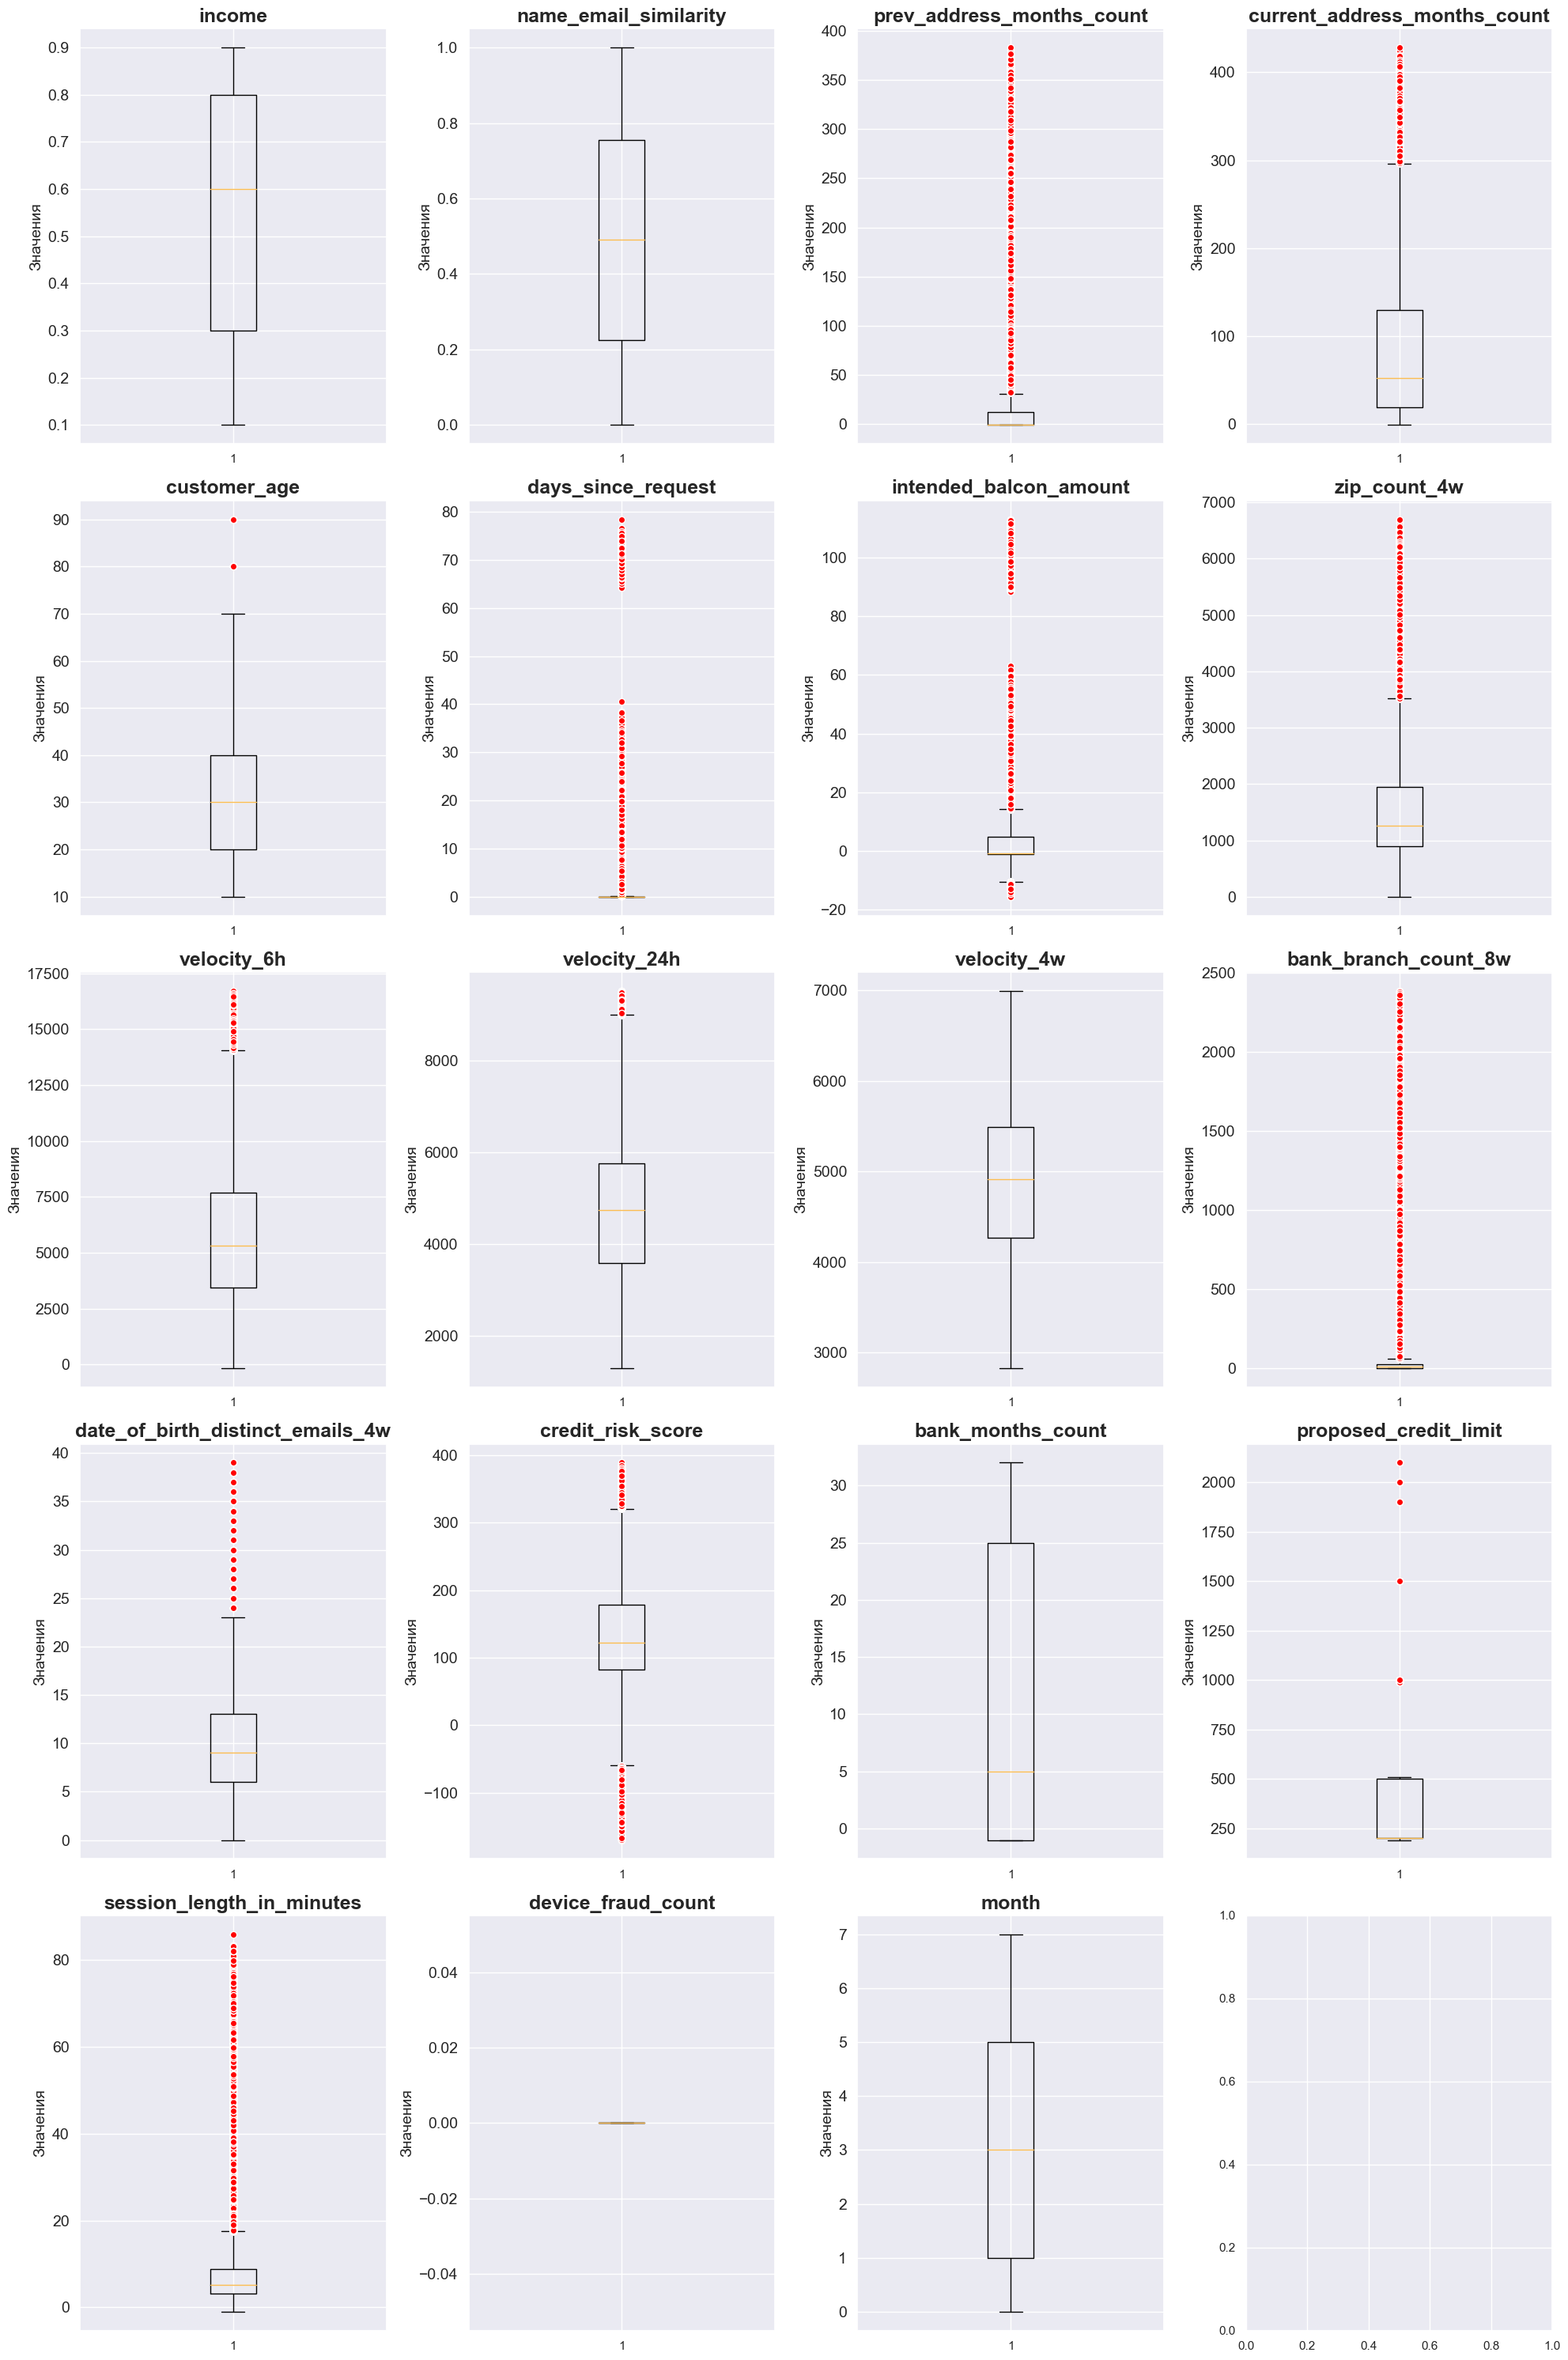

In [31]:
fig, axs = plt.subplots(5, 4, figsize=(20, 30))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
for i, ax in enumerate(axs.flat):
    if i == 19:
      break
    ax.boxplot(df[new_num].iloc[:, i], flierprops=red_circle)
    ax.set_title(new_num[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('Значения', fontsize=14)
    fig.tight_layout()

In [32]:
need_lg_columns = [
 'prev_address_months_count',
 'current_address_months_count',
 'days_since_request',
 'zip_count_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'proposed_credit_limit',
 'session_length_in_minutes',
]

IndexError: single positional indexer is out-of-bounds

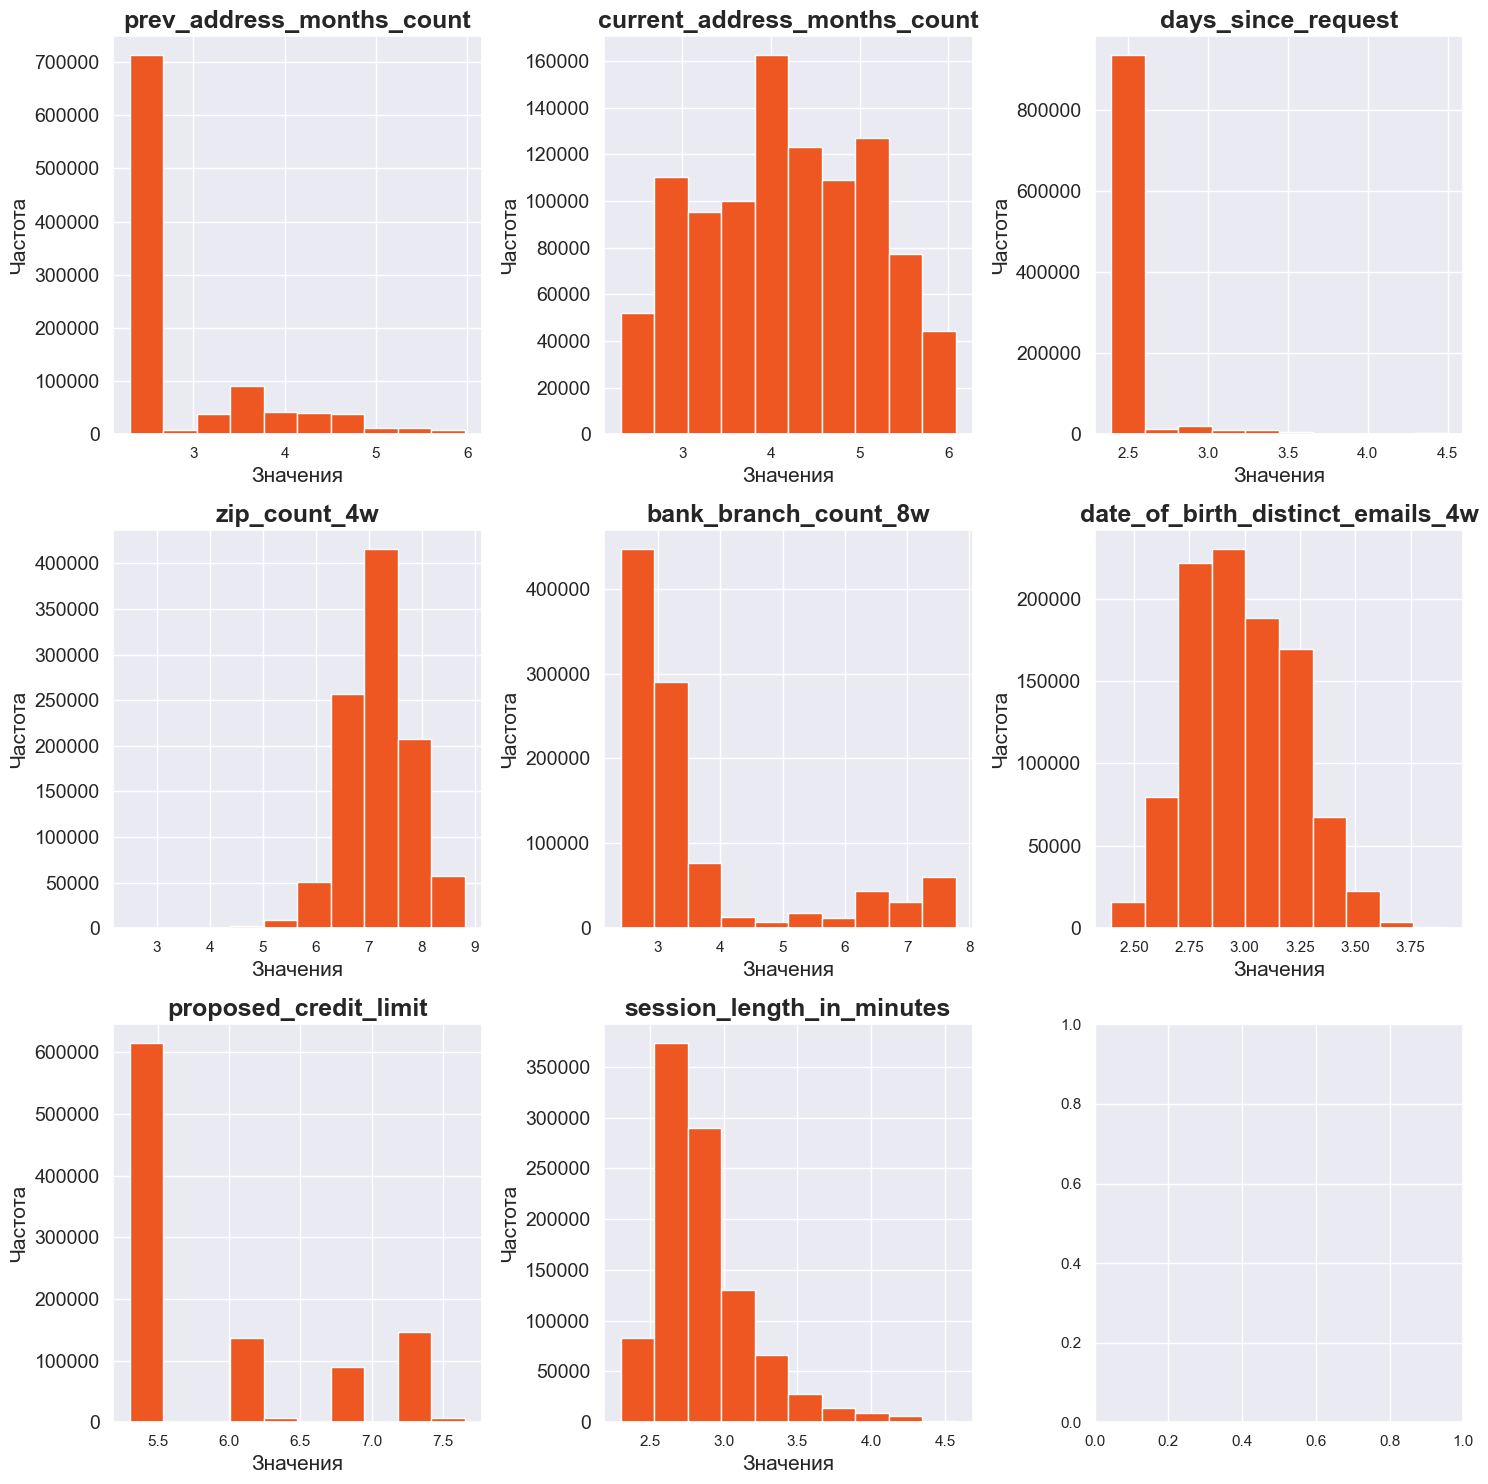

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.hist(np.log1p(df[need_lg_columns]+10)[need_lg_columns].iloc[:, i])
    ax.set_title(need_lg_columns[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    fig.tight_layout()
None

### Логарифмирование помогло
Преобразуем данные

In [34]:
df.loc[:, need_lg_columns] = df.loc[:, need_lg_columns].apply(lambda x: np.log1p(x+10))

## <span style='background-color: #87CEEB'>5) Категориальные переменные </span>

In [35]:
target = 'fraud_bool'

In [36]:
new_cat = [
 'payment_type',
 'employment_status',
 'housing_status',
 'source',
 'device_os',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'keep_alive_session',
 'device_distinct_emails_8w'
 ]

In [37]:
len(new_cat)

12

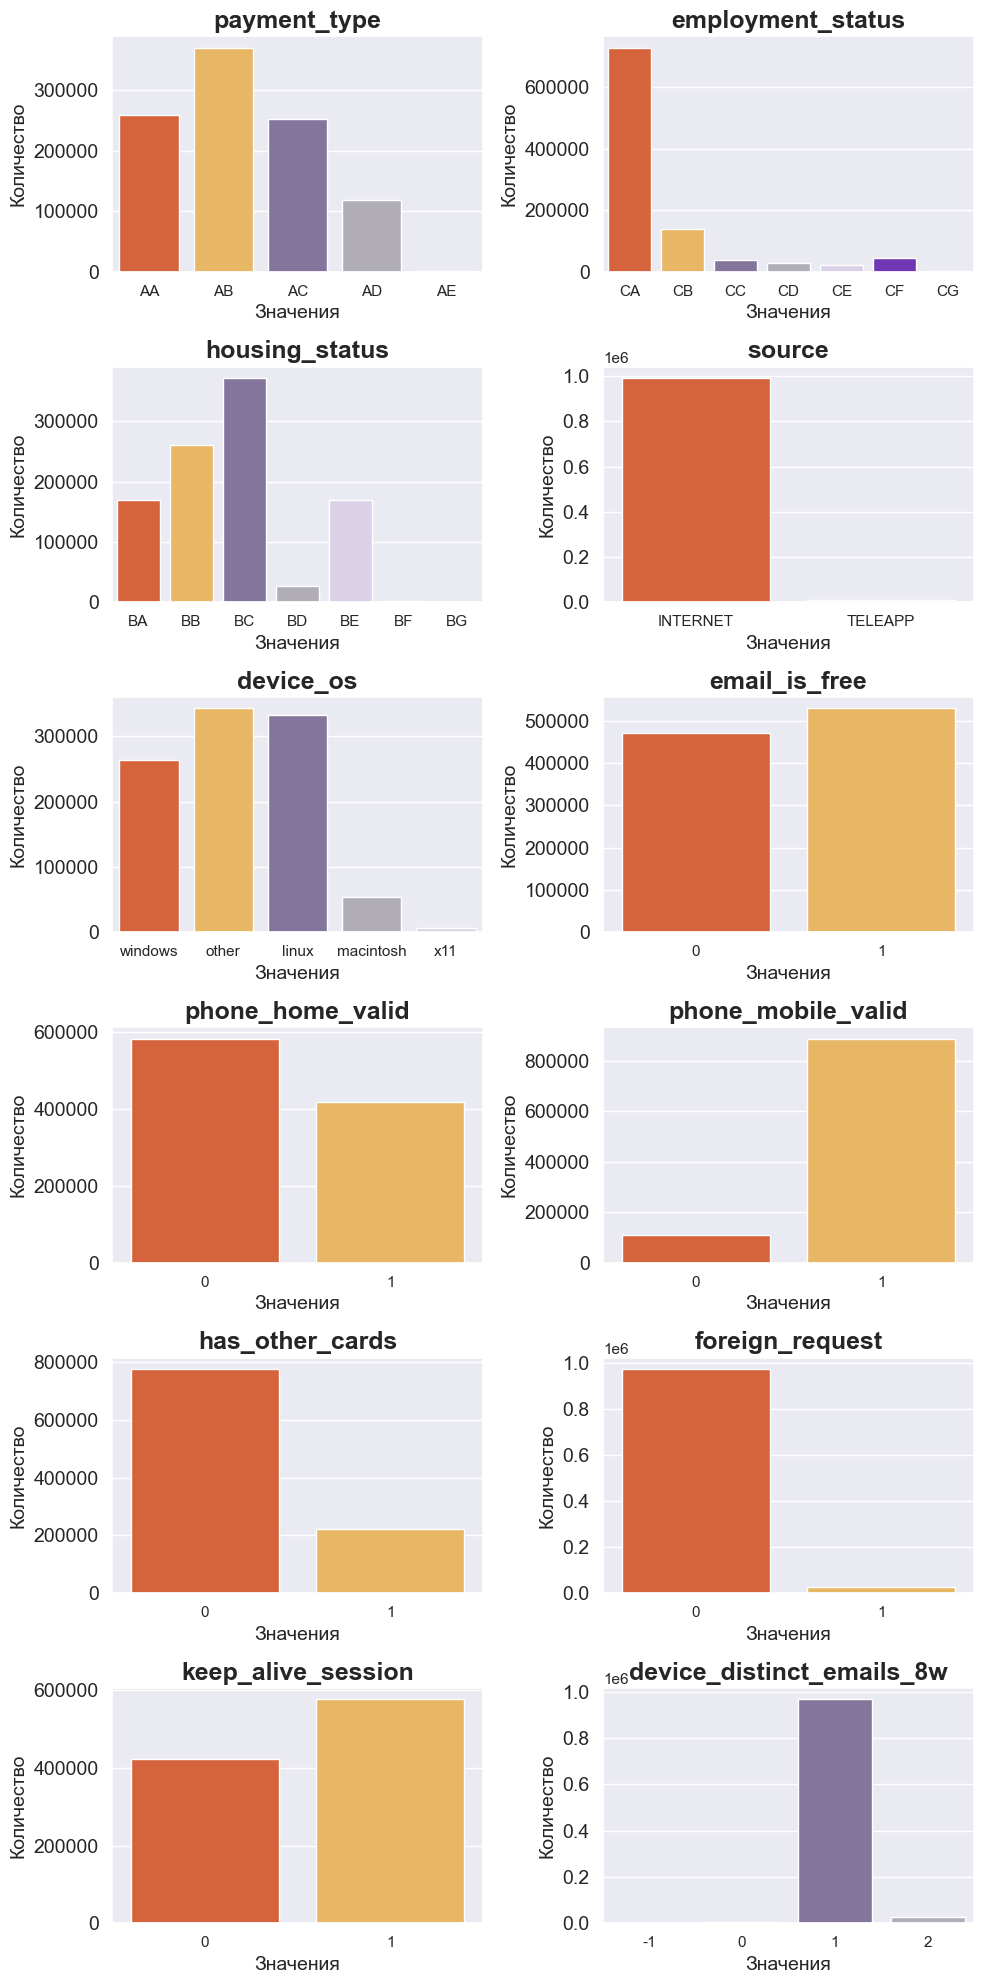

In [38]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
for i, ax in enumerate(axs.flat):
    sns.countplot(df[new_cat].iloc[:, i], ax=ax)
    ax.set_title(new_cat[i], fontsize=18, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Значения', fontsize=14)
    ax.set_ylabel('Количество', fontsize=14)
    fig.tight_layout()

### One Hot Encoding

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Get one-hot-encoded columns
ohe_cat = pd.DataFrame(ohe.fit_transform(df[new_cat]), index=df.index)

In [41]:
ohe_cat

0    1    2    3    4    5    6    7    8    9   ...   32   33   34  \
0       1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
1       0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
2       0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
3       0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  1.0   
4       0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
999995  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
999996  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  1.0   
999997  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
999998  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   
999999  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  1.0   

         35   36   37   38   39   40   41  
0       0.0  1.0  0.0  0.0  0.0  1.0  0.0  
1       0.0  1.0  0.0  0.0  0.0  1.0  0.0  
2       0.0  1.0  0.0  0.0  0.0  1.0  0.0  
3       0.0  1.0  0.0  0.0  0.0  1.0  0.0  
4       0.0  0.0  1.0  0.0  0.0  1.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
999995  0.0  0.0  1.0  0.0  0.0  1.0  0.0  
999996  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
999997  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
999998  0.0  0.0  1.0  0.0  0.0  1.0  0.0  
999999  0.0  1.0  0.0  0.0  0.0  1.0  0.0  

[1000000 rows x 42 columns]

In [43]:
DATA = pd.concat([df[new_num], ohe_cat, df[target]], axis=1)

In [44]:
DATA.head()

income  name_email_similarity  prev_address_months_count  \
0     0.9               0.166828                   2.302585   
1     0.9               0.296286                   2.302585   
2     0.9               0.044985                   2.302585   
3     0.9               0.159511                   2.302585   
4     0.9               0.596414                   2.302585   

   current_address_months_count  customer_age  days_since_request  \
0                      4.595120            50            2.399796   
1                      5.043425            50            2.398388   
2                      4.962845            40            2.646781   
3                      3.496508            50            2.399628   
4                      5.433722            50            2.398299   

   intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  ...   33  \
0               -1.331345      6.659294  10650.765523   3134.319630  ...  0.0   
1               -0.816224      5.932245    534.047319   2670.918292  ...  0.0   
2               -0.755728      6.781058   4048.534263   2893.621498  ...  0.0   
3               -1.205124      6.710523   3457.064063   4054.908412  ...  1.0   
4               -0.773276      6.803505   5020.341679   2728.237159  ...  0.0   

    34   35   36   37   38   39   40   41  fraud_bool  
0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0           1  
1  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0           1  
2  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0           1  
3  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0           1  
4  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0           1  

[5 rows x 62 columns]

In [ ]:
#DATA.to_csv('/content/drive/MyDrive/ВКР/DATA.csv', index=False)

# <span style='background-color: #87CEEB'>6) Подготовка к обучению</span>

In [49]:
DATA.isna().any().any()

False

In [50]:
m = DATA.loc[:,['month', 'fraud_bool']].groupby('month')['fraud_bool'].sum()

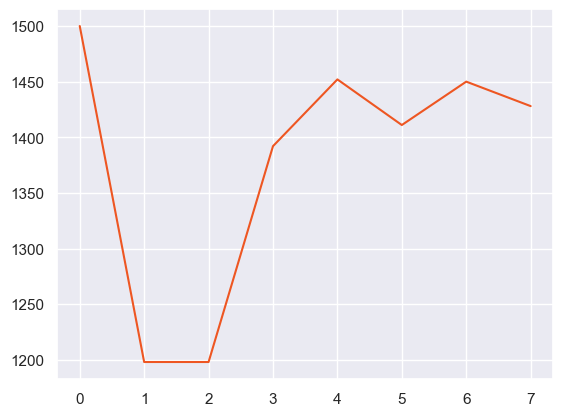

In [51]:
# Количество фрода по месяцам
plt.plot(m)

## <span style='background-color: #87CEEB'>7) Разделим выборку</span>

In [52]:
TRAIN = DATA[DATA.month < 5]
VALID = DATA[(DATA.month >= 5) & (DATA.month < 6)]
TEST = DATA[DATA.month >= 6]

In [53]:
TRAIN.shape

(675666, 62)

In [54]:
# Количество фрода в трейне
TRAIN.fraud_bool.sum()

6740

In [55]:
VALID.shape

(119323, 62)

In [56]:
# Количество фрода в валидационной выборке
VALID.fraud_bool.sum()

1411

In [57]:
TEST.shape

(205011, 62)

In [58]:
# Количество фрода в тестовой выборке
TEST.fraud_bool.sum()

2878

## <span style='background-color: #87CEEB'>8) Отмасштабируем и нормализуем данные </span>

In [59]:
X_train, y_train = TRAIN.iloc[:, :-1],TRAIN.iloc[:, -1]
X_val, y_val = VALID.iloc[:, :-1], VALID.iloc[:, -1]
X_test, y_test = TEST.iloc[:, :-1], TEST.iloc[:, -1]

In [60]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)

In [61]:
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

In [62]:
X_val.shape

(119323, 61)

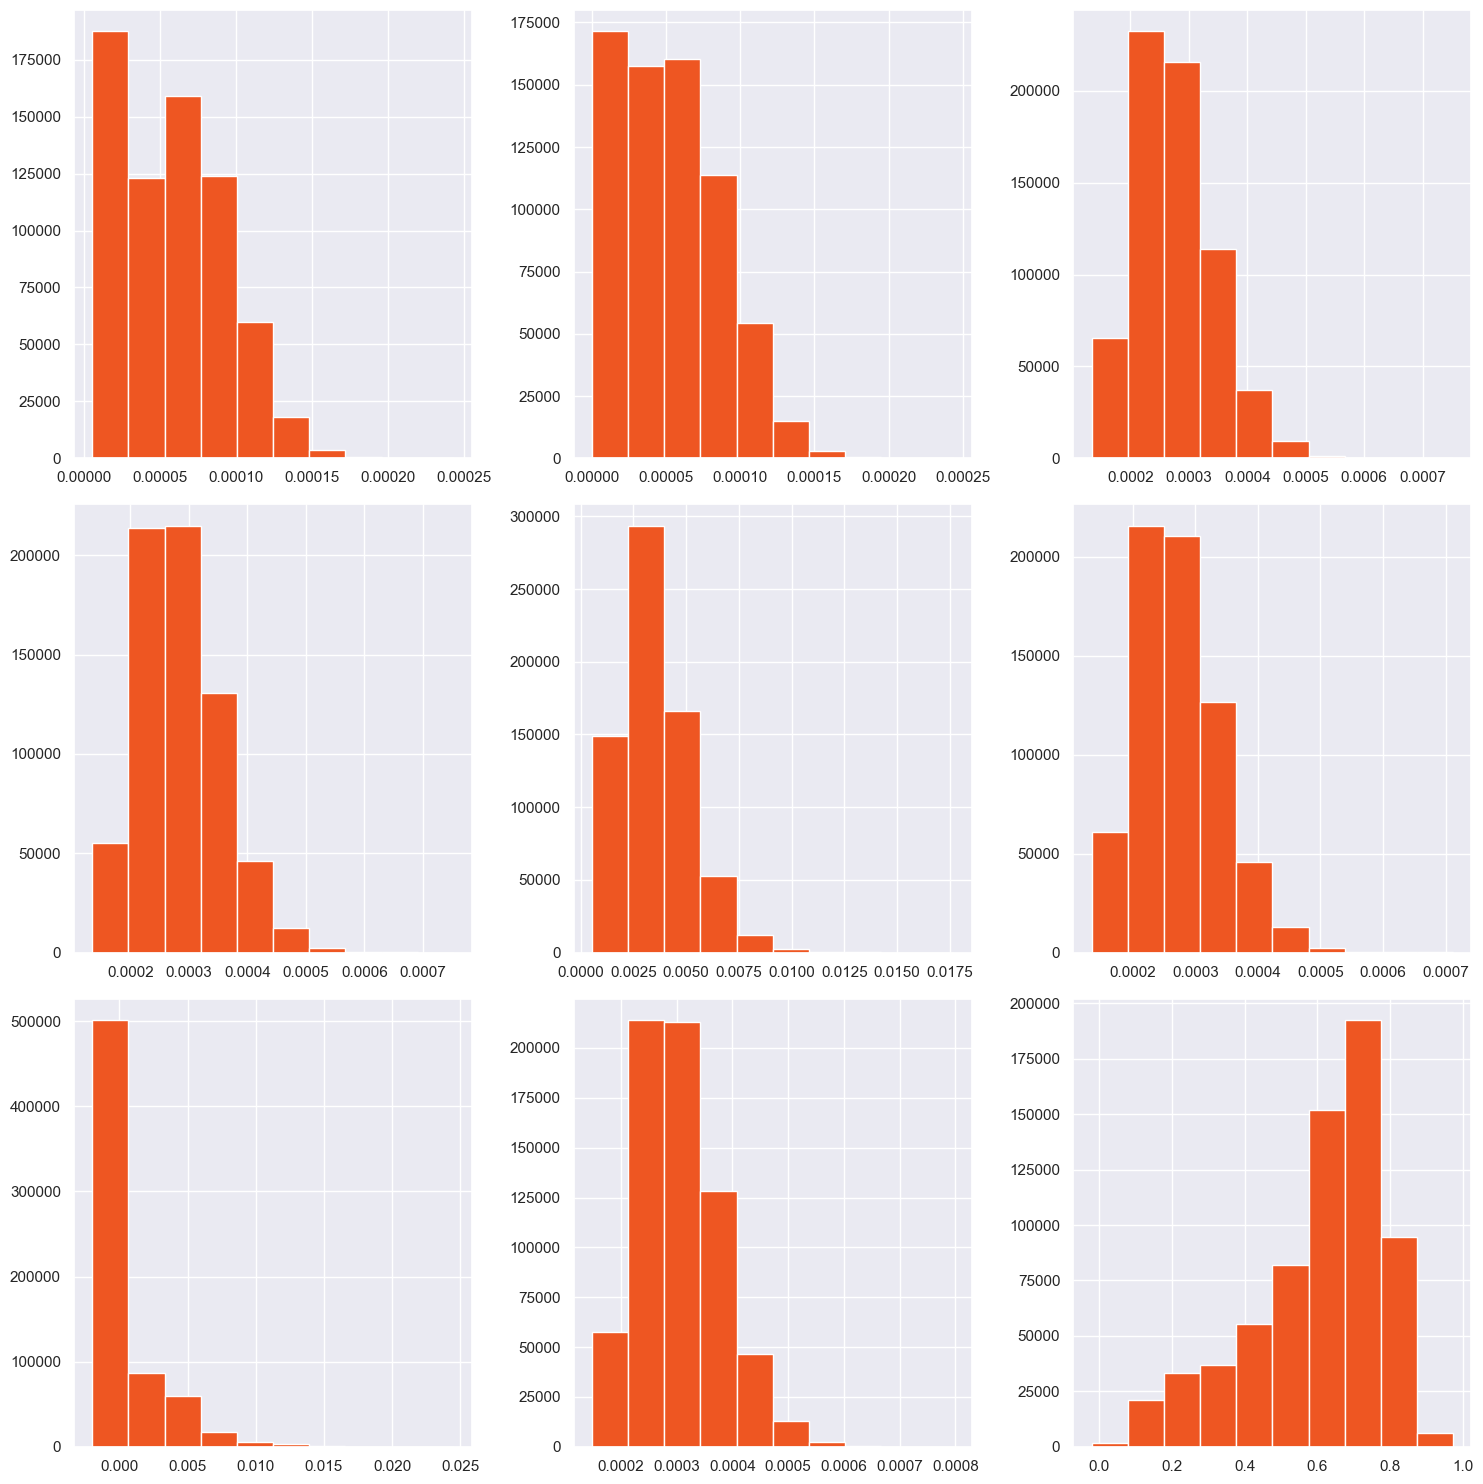

In [63]:
# Визуализируем полученные данные
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.hist(X_train[:, i])
    fig.tight_layout()

# <span style='background-color: #87CEEB'>9) Напишем цикл предобработки данных </span>

In [11]:
# Данные
path = 'D:\Work_dir\Master_work\Data\Bank_Account_Fraud_Dataset_Suite'

In [12]:
df = pd.read_csv(f'{path}/Base.csv')

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer


def prep_data(df) -> pd.DataFrame:
    """INPUT: pandas.DataFrame
        OUTPUT: pandas.DataFrame TRAIN (X, y), VAL (X, y), TEST (X, y)
        
        (splited by time 5/1/1)"""
    
    object_cols = df.dtypes[df.dtypes == 'object'].index.tolist()   
    num_cols = df.dtypes[df.dtypes != 'object'].index.tolist()
    tmp = df.copy()
    
    target = 'fraud_bool'
    
    new_num = ['income',
                 'name_email_similarity',
                 'prev_address_months_count',
                 'current_address_months_count',
                 'customer_age',
                 'days_since_request',
                 'intended_balcon_amount',
                 'zip_count_4w',
                 'velocity_6h',
                 'velocity_24h',
                 'velocity_4w',
                 'bank_branch_count_8w',
                 'date_of_birth_distinct_emails_4w',
                 'credit_risk_score',
                 'bank_months_count',
                 'proposed_credit_limit',
                 'session_length_in_minutes',
                 'device_fraud_count',
                 'month']
    
    need_lg_columns = ['prev_address_months_count',
                 'current_address_months_count',
                 'days_since_request',
                 'zip_count_4w',
                 'bank_branch_count_8w',
                 'date_of_birth_distinct_emails_4w',
                 'proposed_credit_limit',
                 'session_length_in_minutes']
    
    tmp.loc[:, need_lg_columns] = tmp.loc[:, need_lg_columns].apply(lambda x: np.log1p(x+10))
    
    new_cat = ['payment_type',
                 'employment_status',
                 'housing_status',
                 'source',
                 'device_os',
                 'email_is_free',
                 'phone_home_valid',
                 'phone_mobile_valid',
                 'has_other_cards',
                 'foreign_request',
                 'keep_alive_session',
                 'device_distinct_emails_8w']
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    # Get one-hot-encoded columns
    ohe_cat = pd.DataFrame(ohe.fit_transform(tmp[new_cat]), index=tmp.index)
    result = pd.concat([tmp[new_num], ohe_cat, tmp[target]], axis=1)
    
    # Split data
    train = result[result.month < 5]
    valid = result[(result.month >= 5) & (result.month < 6)]
    test = result[result.month >= 6]
    
    # Normalize  
    X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
    X_val, y_val = valid.iloc[:, :-1], valid.iloc[:, -1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
    
    transformer = Normalizer().fit(X_train.values)
    
    # Transform
    X_train_n = transformer.transform(X_train.values)
    X_val_n = transformer.transform(X_val.values)
    X_test_n = transformer.transform(X_test.values)
    
    # Concat
    #TRAIN = pd.concat([X_train_n, y_train], axis=1)
    #VALID = pd.concat([X_val_n, y_val], axis=1)
    #TEST = pd.concat([X_test_n, y_test], axis=1)  
    
    return X_train_n, y_train, X_val_n, y_val, X_test_n, y_test

### Добавим эту функцию в файл base

## <span style='background-color: #87CEEB'>10) Выбор метрик</span>

1. Коэффициент корреляции Мэтьюса

$$MCC = \frac{TP*TN - FP*FN}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$$


2. G-Mean (Cреднее геометрическое чувствительности и специфичности)


$$Sensitivity = \frac{TP}{(TP+FN)}$$


$$Specificity = \frac{TN}{(FP+TN)}$$


$$G-mean = \sqrt{Sensitivity*Specificity}$$

In [9]:
def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # Recall
    recall = tp / (tp + fn)
    # True negatvie rate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    # G-mean
    g_mean = np.sqrt((tp/(tp+fn)) * (tn/(fp+tn)))

    #print("True positive: ", tp)
    #print("False positive: ", fp)
    #print("True negative: ", tn)
    #print("False negative: ", fn)

    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("True negative rate: ", tnr)
    print("ROC-AUC: ", auc)
    print("F1: ", f1)
    print("MCC: ", mcc)
    print("G-mean: ", g_mean)

### Добавим эту функцию в файл base

# <span style='background-color: #D6F99B'> ОБУЧЕНИЕ </span>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import pickle
from tqdm import trange

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier

from catboost import CatBoostClassifier

import seaborn as sns
sns.set(style='darkgrid')
colors = ['#EE5622', '#FCBD51', '#836EA3', '#B1ACB8', '#D9CDEC', '#6E23C9', '#EF7A7A', '#EFBFA0']# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
import warnings
warnings.filterwarnings("ignore")

# Данные
path = 'D:\Work_dir\Master_work\Data\Bank_Account_Fraud_Dataset_Suite'
# Папка с сохраненными  моделями
m_path = 'BAF_models'

In [2]:
# Поместим эту функцию в спомогательный файл
from base import prep_data_baf, metrics

In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_data_baf(path)

In [4]:
k_pca = KernelPCA(n_components=2, kernel='rbf')
X_train_pca = k_pca.fit_transform(X_train[:10000, :])
k_pca = KernelPCA(n_components=2, kernel='rbf')
X_test_pca = k_pca.fit_transform(X_test[:20000, :])

# <span style='background-color: #D6F99B'>Приступим к обучению </span>
## <span style='background-color: #D6F99B'>1) Одноклассовый SVM </span>

In [ ]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
#clf.fit(X_train)

In [ ]:
#pred = clf.predict(X_train)

Сохраним модель

In [ ]:
#with open(f'{m_path}\svm.pickle', 'wb') as f:
#    pickle.dump(clf, f)

In [11]:
with open(f'{m_path}\svm.pickle', 'rb') as f:
    svm = pickle.load(f)

In [13]:
train_svm_pred = svm.predict(X_train)
val_svm_pred = svm.predict(X_val)
test_svm_pred = svm.predict(X_test)

In [39]:
train_svm = (((train_svm_pred-1)/2)**2).astype(int)
val_svm = (((val_svm_pred-1)/2)**2).astype(int)
test_svm = (((test_svm_pred-1)/2)**2).astype(int)

In [38]:
metrics.show_metrics(y_train, train_svm)

True positive rate (recall):  0.05459940652818991
False positive rate:  0.04995320857613548
Precision:  0.010893052718823076
Recall:  0.05459940652818991
True negative rate:  0.9500467914238645
ROC-AUC:  0.5023230989760272
F1:  0.018162524985810526
MCC:  0.008905255733634997
G-mean:  0.22775423373837428


In [40]:
metrics.show_metrics(y_val, val_svm)

True positive rate (recall):  0.05457122608079376
False positive rate:  0.06012958816744691
Precision:  0.010743686340170224
Recall:  0.05457122608079376
True negative rate:  0.939870411832553
ROC-AUC:  0.4972208189566734
F1:  0.01795290277453952
MCC:  -0.0025287703228159745
G-mean:  0.22647269312383556


In [41]:
metrics.show_metrics(y_test, test_svm)

True positive rate (recall):  0.07922168172341904
False positive rate:  0.06287939129187219
Precision:  0.017622507342711393
Recall:  0.07922168172341904
True negative rate:  0.9371206087081279
ROC-AUC:  0.5081711452157734
F1:  0.028831562974203338
MCC:  0.007906971926022164
G-mean:  0.27247067842160927


In [ ]:
pred_10k = svm.predict(X_train[:10000, :])

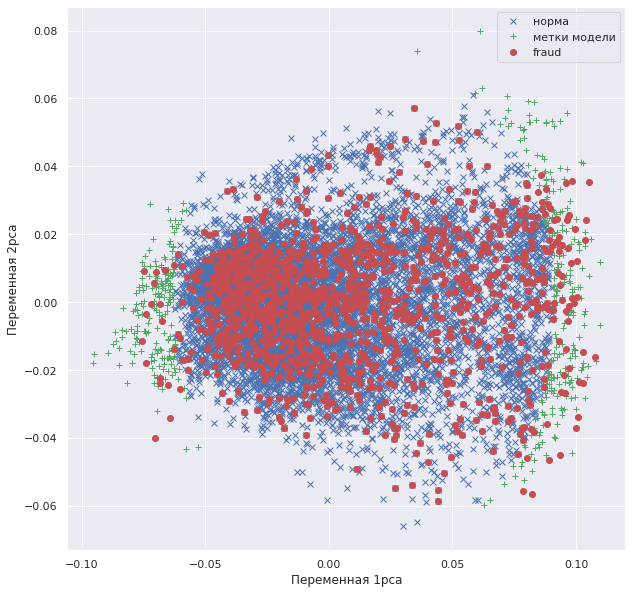

In [ ]:
normal = X_train_pca[pred_10k == 1]
abnormal = X_train_pca[pred_10k == -1]
fraud = X_train_pca[y_train[:10000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы SVM (test):

Recall not fraud:

Recall fraud: 7%

MCC:  0.0079

G-mean:  0.2724

## <span style='background-color: #D6F99B'>2) Isolation Forest </span>

In [ ]:
# Обучение модели
IF = IsolationForest(max_samples=100, contamination=0.1, random_state=42)
#IF.fit(X_train)

IsolationForest(contamination=0.1, max_samples=100, random_state=42)

In [ ]:
#with open(f'{m_path}\Iforest.pickle', 'wb') as f:
#    pickle.dump(IF, f)

In [42]:
with open(f'{m_path}\Iforest.pickle', 'rb') as f:
    IF = pickle.load(f)

In [43]:
# Предсказание
train_IF_pred = IF.predict(X_train)
val_IF_pred = IF.predict(X_val)
test_IF_pred = IF.predict(X_test)

In [45]:
train_IF = (((train_IF_pred-1)/2)**2).astype(int)
val_IF = (((val_IF_pred-1)/2)**2).astype(int)
test_IF = (((test_IF_pred-1)/2)**2).astype(int)

In [46]:
metrics.show_metrics(y_train, train_IF)

True positive rate (recall):  0.1327893175074184
False positive rate:  0.09967021763244364
Precision:  0.013246111267334645
Recall:  0.1327893175074184
True negative rate:  0.9003297823675563
ROC-AUC:  0.5165595499374873
F1:  0.024089251349132652
MCC:  0.16931740592108183
G-mean:  0.34576607313643476


In [51]:
print(classification_report(y_train, train_IF))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    668926
           1       0.01      0.13      0.02      6740

    accuracy                           0.89    675666
   macro avg       0.50      0.52      0.48    675666
weighted avg       0.98      0.89      0.93    675666



In [47]:
metrics.show_metrics(y_val, val_IF)

True positive rate (recall):  0.4408221119773211
False positive rate:  0.39088472759345955
Precision:  0.013315636239082034
Recall:  0.4408221119773211
True negative rate:  0.6091152724065405
ROC-AUC:  0.5249686921919308
F1:  0.02585042495272531
MCC:  0.01105994229097598
G-mean:  0.5181809344426833


In [50]:
print(classification_report(y_val, val_IF))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75    117912
           1       0.01      0.44      0.03      1411

    accuracy                           0.61    119323
   macro avg       0.50      0.52      0.39    119323
weighted avg       0.98      0.61      0.75    119323



In [48]:
metrics.show_metrics(y_test, test_IF)

True positive rate (recall):  0.7428769979152189
False positive rate:  0.7048725344204063
Precision:  0.014783979642639819
Recall:  0.7428769979152189
True negative rate:  0.2951274655795937
ROC-AUC:  0.5190022317474063
F1:  0.028991009803788628
MCC:  0.009808214304033865
G-mean:  0.4682343490519417


In [49]:
print(classification_report(y_test, test_IF))

              precision    recall  f1-score   support

           0       0.99      0.30      0.45    202133
           1       0.01      0.74      0.03      2878

    accuracy                           0.30    205011
   macro avg       0.50      0.52      0.24    205011
weighted avg       0.97      0.30      0.45    205011



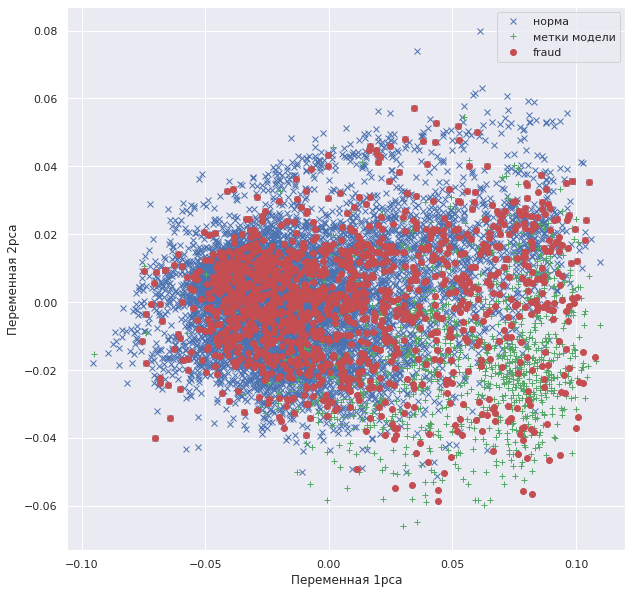

In [ ]:
normal = X_train_pca[y_pred_tr[:10000] == 1]
abnormal = X_train_pca[y_pred_tr[:10000] == -1]
fraud = X_train_pca[y_train[:10000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы Isolation Forest (test):

Recall not fraud: 30%

Recall fraud:  74%

MCC:  0.0098

G-mean:  0.4682

## <span style='background-color: #D6F99B'>3) LogReg </span>

In [ ]:
#LR = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train, y_train)

In [ ]:
#with open(f'{m_path}\LogReg.pickle', 'wb') as f:
#    pickle.dump(LR, f)

In [5]:
with open(f'{m_path}\LogReg.pickle', 'rb') as f:
    LR = pickle.load(f)

In [6]:
# Предсказание
train_LR_pred = LR.predict(X_train)
val_LR_pred = LR.predict(X_val)
test_LR_pred = LR.predict(X_test)

In [7]:
train_LR_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [8]:
metrics.show_metrics(y_train, train_LR_pred)

True positive rate (recall):  0.5902077151335312
False positive rate:  0.3081506773544458
Precision:  0.01893312010965789
Recall:  0.5902077151335312
True negative rate:  0.6918493226455542
ROC-AUC:  0.6410285188895427
F1:  0.03668929388327308
MCC:  nan
G-mean:  0.6390108042398922


In [16]:
print(classification_report(y_train, train_LR_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82    668926
           1       0.02      0.59      0.04      6740

    accuracy                           0.69    675666
   macro avg       0.51      0.64      0.43    675666
weighted avg       0.98      0.69      0.81    675666



In [17]:
metrics.show_metrics(y_val, val_LR_pred)

True positive rate (recall):  0.77462792345854
False positive rate:  0.574521677182984
Precision:  0.015878319483990936
Recall:  0.77462792345854
True negative rate:  0.42547832281701603
ROC-AUC:  0.600053123137778
F1:  0.031118766637721184
MCC:  0.043783004388662984
G-mean:  0.5740970211387336


In [18]:
print(classification_report(y_val, val_LR_pred))

              precision    recall  f1-score   support

           0       0.99      0.43      0.60    117912
           1       0.02      0.77      0.03      1411

    accuracy                           0.43    119323
   macro avg       0.50      0.60      0.31    119323
weighted avg       0.98      0.43      0.59    119323



In [19]:
metrics.show_metrics(y_test, test_LR_pred)

True positive rate (recall):  0.876997915218902
False positive rate:  0.7259725032528088
Precision:  0.016909296763517722
Recall:  0.876997915218902
True negative rate:  0.2740274967471912
ROC-AUC:  0.5755127059830466
F1:  0.03317887541490026
MCC:  0.03993310389304164
G-mean:  0.49022601252885506


In [20]:
print(classification_report(y_test, test_LR_pred))

              precision    recall  f1-score   support

           0       0.99      0.27      0.43    202133
           1       0.02      0.88      0.03      2878

    accuracy                           0.28    205011
   macro avg       0.51      0.58      0.23    205011
weighted avg       0.98      0.28      0.42    205011



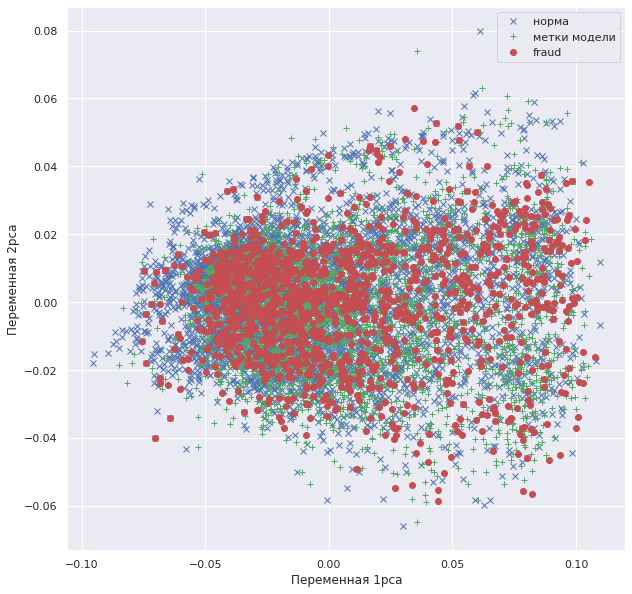

In [ ]:
normal = X_train_pca[y_pred_tr[:10000] == 0]
abnormal = X_train_pca[y_pred_tr[:10000] == 1]
fraud = X_train_pca[y_train[:10000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по Логистической регрессии
Для тестовой выборки:
- Recall not fraud  27%
- Recall fraud  87%
- MCC:   0.0399
- G-mean:  0.4902

Очень плохо!

## <span style='background-color: #D6F99B'>4) LGBM </span>

In [22]:
train_data = lgb.Dataset(X_train, y_train)
val_data = lgb.Dataset(X_val, y_val)
test_data = lgb.Dataset(X_test, y_test)

In [ ]:
params = {'learning_rate': 0.0009,
                'max_depth': 4,
                'num_leaves': 6,
                'feature_fraction': 0.8,
                'subsample': 0.2,
                'objective': 'binary',
                'metric': ['auc', 'tweedie', 'cross_entropy'],
                'is_unbalance':True,
                'bagging_freq':5,
                'boosting':'dart',
                'num_boost_round':5000,
                'early_stopping_rounds':1500}

In [ ]:
bst = lgb.train(params, train_set=train_data, verbose_eval=True, valid_sets=val_data)

[1]	valid_0's xentropy: 0.0640648	valid_0's tweedie: 0.433367	valid_0's auc: 0.777702
[2]	valid_0's xentropy: 0.0637732	valid_0's tweedie: 0.430655	valid_0's auc: 0.792303
[3]	valid_0's xentropy: 0.063545	valid_0's tweedie: 0.42863	valid_0's auc: 0.798316
[4]	valid_0's xentropy: 0.063316	valid_0's tweedie: 0.426665	valid_0's auc: 0.80125
[5]	valid_0's xentropy: 0.0632	valid_0's tweedie: 0.425782	valid_0's auc: 0.811502
[6]	valid_0's xentropy: 0.0630669	valid_0's tweedie: 0.42477	valid_0's auc: 0.816442
[7]	valid_0's xentropy: 0.0629074	valid_0's tweedie: 0.423549	valid_0's auc: 0.815394
[8]	valid_0's xentropy: 0.062965	valid_0's tweedie: 0.42397	valid_0's auc: 0.813346
[9]	valid_0's xentropy: 0.0628311	valid_0's tweedie: 0.423009	valid_0's auc: 0.815629
[10]	valid_0's xentropy: 0.062704	valid_0's tweedie: 0.422113	valid_0's auc: 0.815247
[11]	valid_0's xentropy: 0.062586	valid_0's tweedie: 0.421327	valid_0's auc: 0.815048
[12]	valid_0's xentropy: 0.0626032	valid_0's tweedie: 0.421381	v

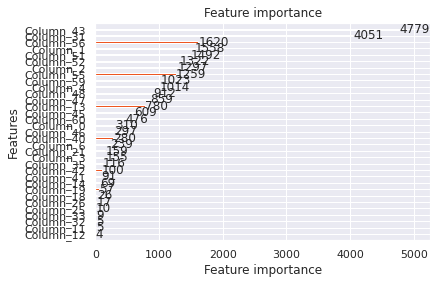

In [ ]:
plot_importance(bst)
plt.show()

In [ ]:
#with open(f'{m_path}\LGBM.pickle', 'wb') as f:
#    pickle.dump(bst, f)

In [23]:
with open(f'{m_path}\LGBM.pickle', 'rb') as f:
    lgbm = pickle.load(f)

In [24]:
# Предсказание
train_lgbm_pred = lgbm.predict(X_train)
val_lgbm_pred = lgbm.predict(X_val)
test_lgbm_pred = lgbm.predict(X_test)

In [25]:
# Найдем лучший порог вероятности
from sklearn.metrics import f1_score

def pred_array(pred, tresh):
    res = []
    for i in pred:
        if i >= tresh:
            res.append(1)
        else:
            res.append(0)
    return np.array(res)

def best_tresh(pred, y_real):
    tresh = {}
    for n in range(20, 90):
        treshhold = float(f'0.{n}')
        res = pred_array(pred, treshhold)
        score = f1_score(y_real, res)
        tresh[treshhold] = score
    
    best_tresh = sorted(tresh.items(), key=lambda item: item[1], reverse =True)[0][0]

    result = pred_array(pred, best_tresh)
    print('best_treshhold:', best_tresh)
    return result

In [26]:
train_lgbm = best_tresh(train_lgbm_pred, y_train)
val_lgbm = best_tresh(val_lgbm_pred, y_val)
test_lgbm = best_tresh(test_lgbm_pred, y_test)

best_treshhold: 0.73
best_treshhold: 0.71
best_treshhold: 0.72


### Метрики

In [78]:
metrics.show_metrics(y_train, train_lgbm)

True positive rate (recall):  0.178486646884273
False positive rate:  0.011664967425395335
Precision:  0.1335776149233844
Recall:  0.178486646884273
True negative rate:  0.9883350325746046
ROC-AUC:  0.5834108397294389
F1:  0.15280071129175662
MCC:  0.2561395891274995
G-mean:  0.42000548325289744


In [79]:
print(classification_report(y_train, train_lgbm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    668926
           1       0.13      0.18      0.15      6740

    accuracy                           0.98    675666
   macro avg       0.56      0.58      0.57    675666
weighted avg       0.98      0.98      0.98    675666



In [80]:
metrics.show_metrics(y_val, val_lgbm)

True positive rate (recall):  0.260099220411056
False positive rate:  0.02172806838998575
Precision:  0.12529873677022874
Recall:  0.260099220411056
True negative rate:  0.9782719316100142
ROC-AUC:  0.6191855760105351
F1:  0.16912442396313365
MCC:  0.1665218482841367
G-mean:  0.5044281581769425


In [81]:
print(classification_report(y_val, val_lgbm))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    117912
           1       0.13      0.26      0.17      1411

    accuracy                           0.97    119323
   macro avg       0.56      0.62      0.58    119323
weighted avg       0.98      0.97      0.97    119323



In [82]:
metrics.show_metrics(y_test, test_lgbm)

True positive rate (recall):  0.25573314801945796
False positive rate:  0.02121870253743822
Precision:  0.1464676616915423
Recall:  0.25573314801945796
True negative rate:  0.9787812974625618
ROC-AUC:  0.6172572227410099
F1:  0.18625838289257243
MCC:  0.17842913698087526
G-mean:  0.5003067283403957


In [83]:
print(classification_report(y_test, test_lgbm))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    202133
           1       0.15      0.26      0.19      2878

    accuracy                           0.97    205011
   macro avg       0.57      0.62      0.59    205011
weighted avg       0.98      0.97      0.97    205011



Recall для тестовой выборки для fraud всего 26%
Precision Recall для Not_fraud 99 и 98%

Это говорит о том, что модели не хватает примеров фрода и она не обучается для него

In [ ]:
k_pca = KernelPCA(n_components=2, kernel='rbf')
X_test_pca = k_pca.fit_transform(X_test[:20000, :])

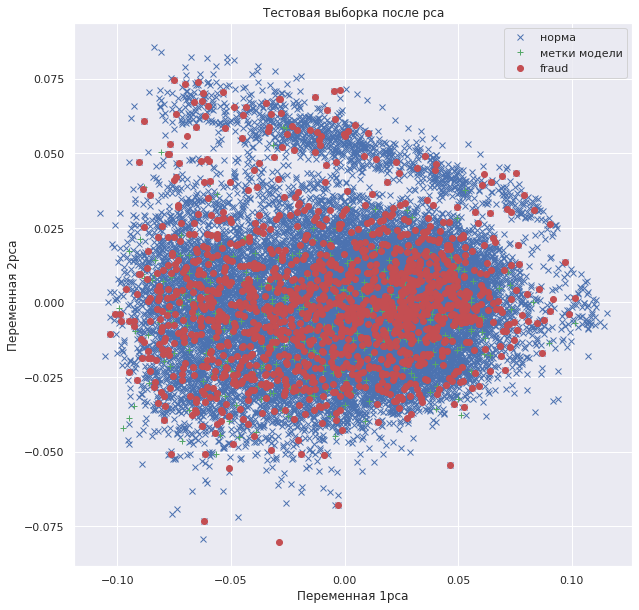

In [ ]:
normal = X_test_pca[test_lgbm[:20000] == 0]
abnormal = X_test_pca[test_lgbm[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

### Выводы по LGBM (test)

Recall fraud: 26%

Recall not fraud: 98%

MCC:  0.1784

G-mean:  0.5003

## <span style='background-color: #D6F99B'>5) CatBoost </span>

Доля классов

In [ ]:
y_train.value_counts()

0    668926
1      6740
Name: fraud_bool, dtype: int64

In [ ]:
# Вес класса 0
y_train.value_counts()[1]/y_train.shape[0]

0.009975342846909568

In [ ]:
# Вес класса 1
y_train.value_counts()[0]/y_train.shape[0]

0.9900246571530904

In [ ]:
model_cbc = CatBoostClassifier(iterations=5000,
                           eval_metric='F1',
                           learning_rate=0.009,
                           custom_loss='AUC',
                           use_best_model=True,
                           random_state=42,
                           class_weights={0: 0.00997, 1: 0.99},
                           verbose=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
model_cbc.fit(X_train, y_train,
          verbose=True,
          eval_set = (X_val, y_val),
          plot=False)

Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 0.7579181	test: 0.7536698	best: 0.7579283 (0)	total: 2.51s	remaining: 34m 47s
6:	learn: 0.7578676	test: 0.7540448	best: 0.7579283 (0)	total: 2.97s	remaining: 35m 21s
7:	learn: 0.7535222	test: 0.7501898	best: 0.7579283 (0)	total: 3.44s	remaining: 35m 47s
8:	learn: 0.7534232	test: 0.7503747	best: 0.7579283 (0)	total: 3.96s	remaining: 36m 34s
9:	learn: 0.7554697	test: 0.7522314	best: 0.7579283 (0)	total: 4.47s	remaining: 37m 10s
10:	learn: 0.7551620	test: 0.7511162	best: 0.7579283 (0)	total: 4.88s	remaining: 36m 51s
11:	learn: 0.7521726	test: 0.7487524	best: 0.7579283 (0)	total: 5.12s	remaining: 35m 29s
12:	learn: 0.7536972	test: 0.7490467	best: 0.7579283 (0)	total: 5.35s	remaining: 34m 13s
13:	learn: 0.7537549	test: 0.7504624	best: 0.7579283 (0)	total: 5.62s	remaining: 33m 21s
14:	learn: 0.7535934	test: 0.7505816	best: 0.7579283 (0)	total: 5.86s	remaining: 32m 27s
15:	learn: 0.7542576	test: 0.7502939	best: 0.75

In [ ]:
#with open(f'{m_path}\CatBoost.pickle', 'wb') as f:
#    pickle.dump(model_cbc, f)

In [9]:
with open(f'{m_path}\CatBoost.pickle', 'rb') as f:
    cbc = pickle.load(f)

In [10]:
# Предсказание
train_cbc_pred = cbc.predict(X_train)
val_cbc_pred = cbc.predict(X_val)
test_cbc_pred = cbc.predict(X_test)

### Метрики

In [12]:
metrics.show_metrics(y_train, train_cbc_pred)

True positive rate (recall):  0.8155786350148369
False positive rate:  0.1815821182014154
Precision:  0.04329641940108064
Recall:  0.8155786350148369
True negative rate:  0.8184178817985845
ROC-AUC:  0.8169982584067107
F1:  0.0822276405738134
MCC:  4.074006140648821
G-mean:  0.8169970250307058


In [13]:
print(classification_report(y_train, train_cbc_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    668926
           1       0.04      0.82      0.08      6740

    accuracy                           0.82    675666
   macro avg       0.52      0.82      0.49    675666
weighted avg       0.99      0.82      0.89    675666



In [14]:
metrics.show_metrics(y_val, val_cbc_pred)

True positive rate (recall):  0.7306874557051737
False positive rate:  0.14715211344053192
Precision:  0.056087476879556085
Recall:  0.7306874557051737
True negative rate:  0.8528478865594681
ROC-AUC:  0.7917676711323209
F1:  0.10417824483403224
MCC:  0.1747348341192053
G-mean:  0.789408165864575


In [15]:
print(classification_report(y_val, val_cbc_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    117912
           1       0.06      0.73      0.10      1411

    accuracy                           0.85    119323
   macro avg       0.53      0.79      0.51    119323
weighted avg       0.99      0.85      0.91    119323



In [16]:
metrics.show_metrics(y_test, test_cbc_pred)

True positive rate (recall):  0.7592077831827658
False positive rate:  0.16531689531150282
Precision:  0.061374680486503186
Recall:  0.7592077831827658
True negative rate:  0.8346831046884972
ROC-AUC:  0.7969454439356315
F1:  0.11356843992827256
MCC:  0.18444634251562056
G-mean:  0.7960514490726478


In [17]:
print(classification_report(y_test, test_cbc_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    202133
           1       0.06      0.76      0.11      2878

    accuracy                           0.83    205011
   macro avg       0.53      0.80      0.51    205011
weighted avg       0.98      0.83      0.90    205011



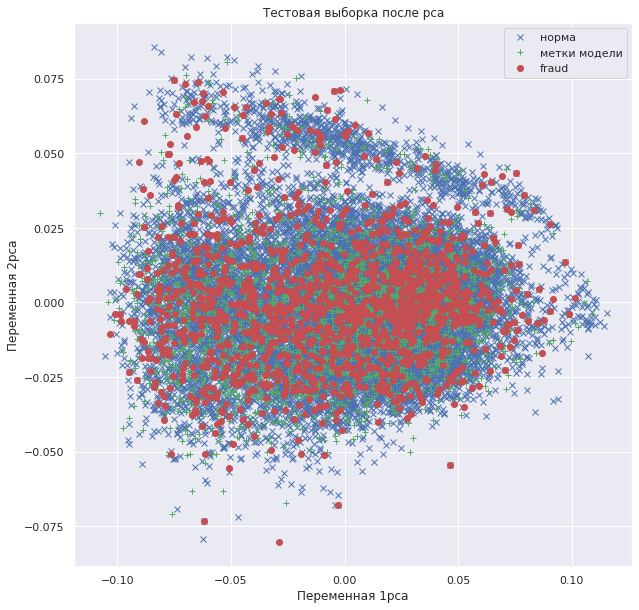

In [ ]:
normal = X_test_pca[test_cbc_pred[:20000] == 0]
abnormal = X_test_pca[test_cbc_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по CatBoost (test)
Recall для not_fraud 83%

Recall для fraud 76%

MCC:    0.1844

G-mean: 0.7960

Очень хороший результат!

## <span style='background-color: #D6F99B'>6) Decision Tree </span>

In [22]:
model_dt = DecisionTreeClassifier(max_depth=11, class_weight='balanced')

In [23]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=11)

In [24]:
#with open(f'{m_path}\DecisionTree.pickle', 'wb') as f:
#    pickle.dump(model_dt, f)

In [25]:
with open(f'{m_path}\DecisionTree.pickle', 'rb') as f:
    dt = pickle.load(f)

In [26]:
# Предсказание
train_dt_pred = dt.predict(X_train)
val_dt_pred = dt.predict(X_val)
test_dt_pred = dt.predict(X_test)

### Метрики

In [27]:
metrics.show_metrics(y_train, train_dt_pred)

True positive rate (recall):  0.8675074183976261
False positive rate:  0.1874093696462688
Precision:  0.04456215227497904
Recall:  0.8675074183976261
True negative rate:  0.8125906303537311
ROC-AUC:  0.8400490243756786
F1:  0.08476984414642987
MCC:  1.0524460787866015
G-mean:  0.8396001428967631


In [28]:
print(classification_report(y_train, train_dt_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90    668926
           1       0.04      0.87      0.08      6740

    accuracy                           0.81    675666
   macro avg       0.52      0.84      0.49    675666
weighted avg       0.99      0.81      0.89    675666



In [29]:
metrics.show_metrics(y_val, val_dt_pred)

True positive rate (recall):  0.5988660524450744
False positive rate:  0.15240179116629352
Precision:  0.04491097528567632
Recall:  0.5988660524450744
True negative rate:  0.8475982088337065
ROC-AUC:  0.7232321306393905
F1:  0.08355581924255909
MCC:  0.1324270738940942
G-mean:  0.7124589766321691


In [30]:
print(classification_report(y_val, val_dt_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92    117912
           1       0.04      0.60      0.08      1411

    accuracy                           0.84    119323
   macro avg       0.52      0.72      0.50    119323
weighted avg       0.98      0.84      0.91    119323



In [31]:
metrics.show_metrics(y_test, test_dt_pred)

True positive rate (recall):  0.5840861709520501
False positive rate:  0.1517812529374224
Precision:  0.05194524273044714
Recall:  0.5840861709520501
True negative rate:  0.8482187470625776
ROC-AUC:  0.7161524590073138
F1:  0.09540565850336274
MCC:  0.13949541196443094
G-mean:  0.703869902824042


In [32]:
print(classification_report(y_test, test_dt_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    202133
           1       0.05      0.58      0.10      2878

    accuracy                           0.84    205011
   macro avg       0.52      0.72      0.51    205011
weighted avg       0.98      0.84      0.90    205011



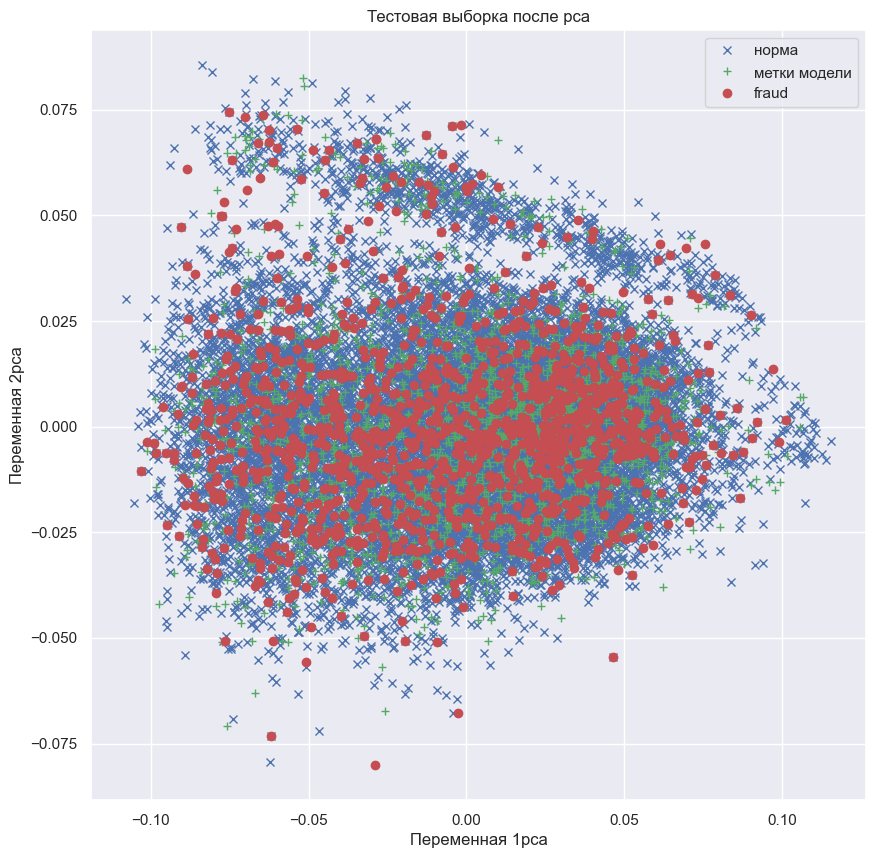

In [36]:
normal = X_test_pca[test_dt_pred[:20000] == 0]
abnormal = X_test_pca[test_dt_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по DT (test)

Recall not fraud 85%

Recall fraud 58%

MCC:  0.1324

G-mean:  0.7124

## <span style='background-color: #D6F99B'>7) Random Forest </span>

In [37]:
model_rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=5, class_weight='balanced')

In [38]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                       random_state=42)

In [39]:
#with open(f'{m_path}\RandomForest.pickle', 'wb') as f:
#    pickle.dump(model_rf, f)

In [40]:
with open(f'{m_path}\RandomForest.pickle', 'rb') as f:
    rf = pickle.load(f)

In [41]:
# Предсказание
train_rf_pred = rf.predict(X_train)
val_rf_pred = rf.predict(X_val)
test_rf_pred = rf.predict(X_test)

### Метрики

In [42]:
metrics.show_metrics(y_train, train_rf_pred)

True positive rate (recall):  0.7495548961424332
False positive rate:  0.19985319751362632
Precision:  0.03641369766251739
Recall:  0.7495548961424332
True negative rate:  0.8001468024863737
ROC-AUC:  0.7748508493144035
F1:  0.06945332316004371
MCC:  1.2691090437945582
G-mean:  0.7744378305818833


In [43]:
print(classification_report(y_train, train_rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89    668926
           1       0.04      0.75      0.07      6740

    accuracy                           0.80    675666
   macro avg       0.52      0.77      0.48    675666
weighted avg       0.99      0.80      0.88    675666



In [44]:
metrics.show_metrics(y_val, val_rf_pred)

True positive rate (recall):  0.7321048901488306
False positive rate:  0.19987787502544271
Precision:  0.041990163001504
Recall:  0.7321048901488306
True negative rate:  0.8001221249745573
ROC-AUC:  0.7661135075616939
F1:  0.07942488082423498
MCC:  0.14221244875627143
G-mean:  0.7653582954473984


In [45]:
print(classification_report(y_val, val_rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89    117912
           1       0.04      0.73      0.08      1411

    accuracy                           0.80    119323
   macro avg       0.52      0.77      0.48    119323
weighted avg       0.98      0.80      0.88    119323



In [46]:
metrics.show_metrics(y_test, test_rf_pred)

True positive rate (recall):  0.7842251563585824
False positive rate:  0.23895652862224376
Precision:  0.044641797539459634
Recall:  0.7842251563585824
True negative rate:  0.7610434713777563
ROC-AUC:  0.7726343138681693
F1:  0.08447488584474885
MCC:  0.14882688772729036
G-mean:  0.7725473676978643


In [47]:
print(classification_report(y_test, test_rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    202133
           1       0.04      0.78      0.08      2878

    accuracy                           0.76    205011
   macro avg       0.52      0.77      0.47    205011
weighted avg       0.98      0.76      0.85    205011



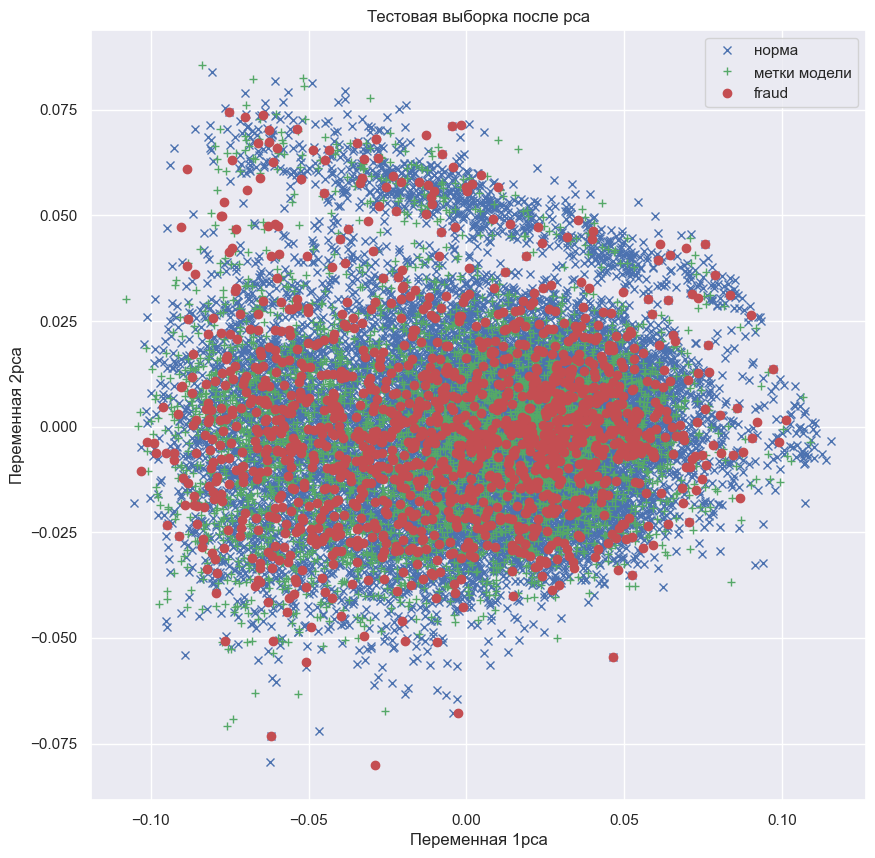

In [48]:
normal = X_test_pca[test_rf_pred[:20000] == 0]
abnormal = X_test_pca[test_rf_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по RF (test)

Recall not fraud 76 %

Recall fraud 78 %

MCC:  0.1488

G-mean:  0.7725

## <span style='background-color: #D6F99B'>8) MLP Classifier </span>

In [50]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=42,
                    hidden_layer_sizes=[1000, 500, 100])

In [51]:
mlp.fit(X_train, y_train)

MLPClassifier(alpha=1, hidden_layer_sizes=[1000, 500, 100], max_iter=1000,
              random_state=42)

In [52]:
#with open(f'{m_path}\MLP.pickle', 'wb') as f:
#    pickle.dump(mlp, f)

In [54]:
with open(f'{m_path}\MLP.pickle', 'rb') as f:
    mlp = pickle.load(f)

In [55]:
# Предсказание
train_mlp_pred = mlp.predict(X_train)
val_mlp_pred = mlp.predict(X_val)
test_mlp_pred = mlp.predict(X_test)

### Метрики

In [56]:
metrics.show_metrics(y_train, train_mlp_pred)

True positive rate (recall):  0.0
False positive rate:  0.0
Precision:  nan
Recall:  0.0
True negative rate:  1.0
ROC-AUC:  0.5
F1:  0.0
MCC:  nan
G-mean:  0.0


In [57]:
print(classification_report(y_train, train_mlp_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    668926
           1       0.00      0.00      0.00      6740

    accuracy                           0.99    675666
   macro avg       0.50      0.50      0.50    675666
weighted avg       0.98      0.99      0.99    675666



In [58]:
metrics.show_metrics(y_val, val_mlp_pred)

True positive rate (recall):  0.0
False positive rate:  0.0
Precision:  nan
Recall:  0.0
True negative rate:  1.0
ROC-AUC:  0.5
F1:  0.0
MCC:  nan
G-mean:  0.0


In [59]:
print(classification_report(y_val, val_mlp_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    117912
           1       0.00      0.00      0.00      1411

    accuracy                           0.99    119323
   macro avg       0.49      0.50      0.50    119323
weighted avg       0.98      0.99      0.98    119323



In [60]:
metrics.show_metrics(y_test, test_mlp_pred)

True positive rate (recall):  0.0
False positive rate:  0.0
Precision:  nan
Recall:  0.0
True negative rate:  1.0
ROC-AUC:  0.5
F1:  0.0
MCC:  nan
G-mean:  0.0


In [61]:
print(classification_report(y_test, test_mlp_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.00      0.00      0.00      2878

    accuracy                           0.99    205011
   macro avg       0.49      0.50      0.50    205011
weighted avg       0.97      0.99      0.98    205011



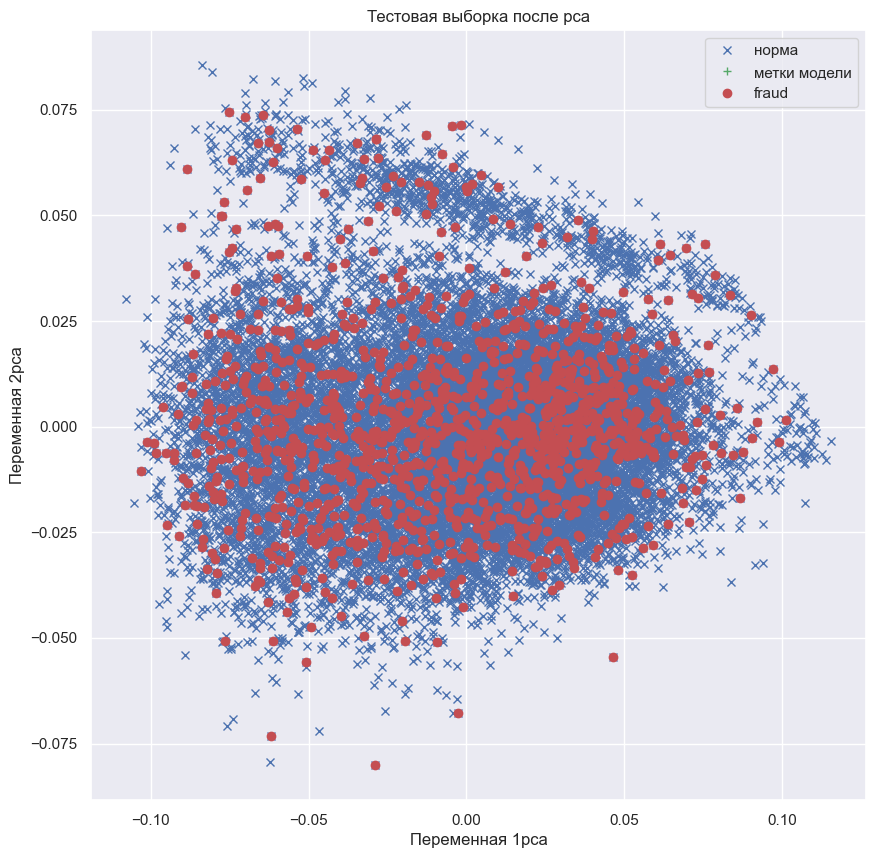

In [62]:
normal = X_test_pca[test_mlp_pred[:20000] == 0]
abnormal = X_test_pca[test_mlp_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по MLPClassifier (test)

Recall not fraud  100 %

Recall fraud  0 %

MCC:  0.0

G-mean:  0.0

## <span style='background-color: #D6F99B'>9) HistGradientBoostingClassifier </span>

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [8]:
hgb = HistGradientBoostingClassifier(class_weight="balanced",
                                     learning_rate=0.05,
                                     max_iter=300,
                                     min_samples_leaf=5,
                                     max_depth=9,
                                     random_state=42)

In [9]:
hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.05,
                               max_depth=9, max_iter=300, min_samples_leaf=5,
                               random_state=42)

In [10]:
#with open(f'{m_path}\HistGradientBoosting.pickle', 'wb') as f:
#    pickle.dump(hgb, f)

In [11]:
with open(f'{m_path}\HistGradientBoosting.pickle', 'rb') as f:
    hgb = pickle.load(f)

In [12]:
# Предсказание
train_hgb_pred = hgb.predict(X_train)
val_hgb_pred = hgb.predict(X_val)
test_hgb_pred = hgb.predict(X_test)

### Метрики

In [13]:
metrics.show_metrics(y_train, train_hgb_pred)

True positive rate (recall):  0.8590504451038575
False positive rate:  0.1668734658243214
Precision:  0.04931184847039586
Recall:  0.8590504451038575
True negative rate:  0.8331265341756786
ROC-AUC:  0.846088489639768
F1:  0.09326975740197815
MCC:  5.083044148683296
G-mean:  0.8459891961552766


In [14]:
print(classification_report(y_train, train_hgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    668926
           1       0.05      0.86      0.09      6740

    accuracy                           0.83    675666
   macro avg       0.52      0.85      0.50    675666
weighted avg       0.99      0.83      0.90    675666



In [15]:
metrics.show_metrics(y_val, val_hgb_pred)

True positive rate (recall):  0.7065910701630049
False positive rate:  0.12852805482054414
Precision:  0.061726102030708274
Recall:  0.7065910701630049
True negative rate:  0.8714719451794559
ROC-AUC:  0.7890315076712304
F1:  0.11353413425952286
MCC:  0.18265254202475678
G-mean:  0.7847128738343645


In [16]:
print(classification_report(y_val, val_hgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    117912
           1       0.06      0.71      0.11      1411

    accuracy                           0.87    119323
   macro avg       0.53      0.79      0.52    119323
weighted avg       0.98      0.87      0.92    119323



In [17]:
metrics.show_metrics(y_test, test_hgb_pred)

True positive rate (recall):  0.7223766504517025
False positive rate:  0.14613150747280257
Precision:  0.06575576430401367
Recall:  0.7223766504517025
True negative rate:  0.8538684925271974
ROC-AUC:  0.78812257148945
F1:  0.12053920858095377
MCC:  0.18771281441434803
G-mean:  0.7853754908055391


In [18]:
print(classification_report(y_test, test_hgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    202133
           1       0.07      0.72      0.12      2878

    accuracy                           0.85    205011
   macro avg       0.53      0.79      0.52    205011
weighted avg       0.98      0.85      0.91    205011



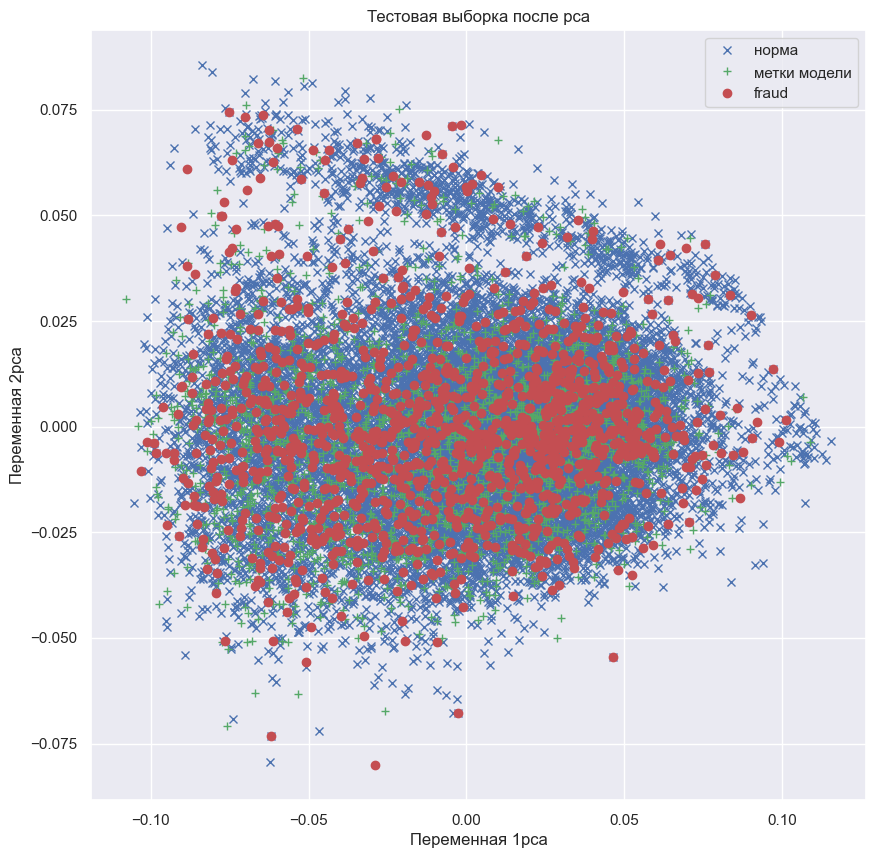

In [19]:
normal = X_test_pca[test_hgb_pred[:20000] == 0]
abnormal = X_test_pca[test_hgb_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

## Выводы по HistGradientBoosting (test)

Recall not fraud  85 %

Recall fraud  72 %

MCC:  0.1877

G-mean:  0.7853

## <span style='background-color: #D6F99B'>10) Ensemble-Stacking </span>

In [12]:
# Звуковое оповещение о выполнении ячейки
from ringbell import RingBell

In [14]:
estimators = [
    ('model_DT', DecisionTreeClassifier(
        class_weight='balanced',
        criterion='entropy',
        max_depth=9,
        random_state=42)
    ),
    ('model_RF', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=300,
        random_state=42,
        max_depth=5)
    ),
    ('model_GBC', HistGradientBoostingClassifier(
        class_weight="balanced",
        learning_rate=0.05,
        max_iter=300,
        min_samples_leaf=5,
        max_depth=9,
        random_state=42)
    )
    ]


model_stack = StackingClassifier(
                                estimators=estimators,
                                final_estimator=LogisticRegression(class_weight='balanced',
                                                                    solver='sag',
                                                                    random_state=42,
                                                                    max_iter=1000)
)

In [15]:
%%time
model_stack.fit(X_train, y_train)

Wall time: 35min 22s


StackingClassifier(estimators=[('model_DT',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=9,
                                                       random_state=42)),
                               ('model_RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('model_GBC',
                                HistGradientBoostingClassifier(class_weight='balanced',
                                                               learning_rate=0.05,
                                                               max_depth=9,
                                                               max_iter=300,
                                                               min_samples_leaf=5,
                                                               random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [29]:
RingBell(sample = "microwave",
        minimum_execution_time = 0, verbose = True)

In [30]:
#with open(f'{m_path}\StackingClassifier.pickle', 'wb') as f:
#    pickle.dump(model_stack, f)

In [4]:
with open(f'{m_path}\StackingClassifier.pickle', 'rb') as f:
    model_stack = pickle.load(f)

In [5]:
# Предсказание
train_model_stack_pred = model_stack.predict(X_train)
val_model_stack_pred = model_stack.predict(X_val)
test_model_stack_pred = model_stack.predict(X_test)

In [6]:
train_model_stack_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

### Метрики

In [34]:
metrics.show_metrics(y_train, train_model_stack_pred)

True positive rate (recall):  0.5161721068249259
False positive rate:  0.050149044886878366
Precision:  0.09396353814989872
Recall:  0.5161721068249259
True negative rate:  0.9498509551131217
ROC-AUC:  0.7330115309690237
F1:  0.15898549068890666
MCC:  nan
G-mean:  0.7002046619884847


In [22]:
print(classification_report(y_train, train_model_stack_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    668926
           1       0.09      0.52      0.16      6740

    accuracy                           0.95    675666
   macro avg       0.54      0.73      0.57    675666
weighted avg       0.99      0.95      0.96    675666



In [10]:
metrics.show_metrics(y_val, val_model_stack_pred)

True positive rate (recall):  0.442239546420978
False positive rate:  0.04253171856978085
Precision:  0.11065791807057988
Recall:  0.442239546420978
True negative rate:  0.9574682814302191
ROC-AUC:  0.6998539139255986
F1:  0.17702127659574468
MCC:  0.20362656870870346
G-mean:  0.6507152514673169


In [11]:
print(classification_report(y_val, val_model_stack_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    117912
           1       0.11      0.44      0.18      1411

    accuracy                           0.95    119323
   macro avg       0.55      0.70      0.58    119323
weighted avg       0.98      0.95      0.97    119323



In [37]:
metrics.show_metrics(y_test, test_model_stack_pred)

True positive rate (recall):  0.46177901320361364
False positive rate:  0.05398425788960734
Precision:  0.10856956131035046
Recall:  0.46177901320361364
True negative rate:  0.9460157421103926
ROC-AUC:  0.7038973776570031
F1:  0.17580527812686025
MCC:  0.20247782591630636
G-mean:  0.6609464546140038


In [38]:
print(classification_report(y_test, test_model_stack_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.11      0.46      0.18      2878

    accuracy                           0.94    205011
   macro avg       0.55      0.70      0.57    205011
weighted avg       0.98      0.94      0.96    205011



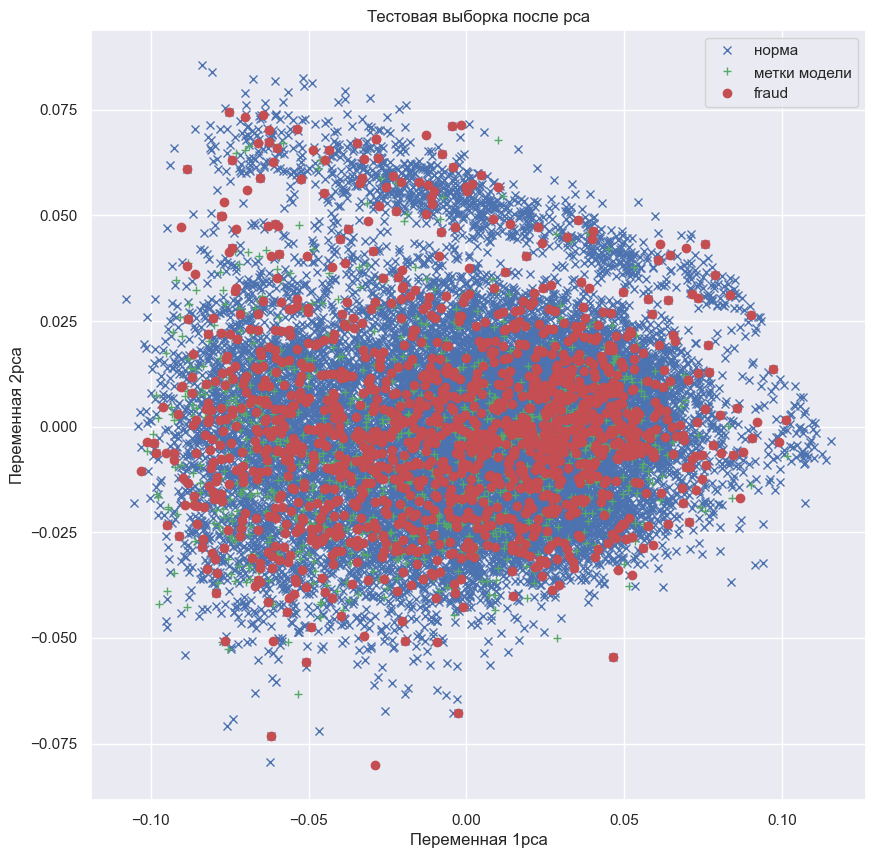

In [40]:
normal = X_test_pca[test_model_stack_pred[:20000] == 0]
abnormal = X_test_pca[test_model_stack_pred[:20000] == 1]
fraud = X_test_pca[y_test[:20000] == 1]

plt.figure(figsize=(10,10))
plt.plot(normal[:,0], normal[:,1], 'bx', label='норма')
plt.plot(abnormal[:,0], abnormal[:,1],'g+', label='метки модели')
plt.plot(fraud[:,0], fraud[:,1], 'ro', label='fraud')
plt.title('Тестовая выборка после pca')
plt.xlabel('Переменная 1pca')
plt.ylabel('Переменная 2pca')
plt.legend();
plt.show()

# <span style='background-color: #D6F99B'>Подведение итогов</span>

In [4]:
models_names = os.listdir(m_path)

In [5]:
names = []
for model in models_names:
    names.append(model.split('.')[0])

In [66]:
models_names

['CatBoost.pickle',
 'DecisionTree.pickle',
 'HistGradientBoosting.pickle',
 'Iforest.pickle',
 'LGBM.pickle',
 'LogReg.pickle',
 'MLP.pickle',
 'RandomForest.pickle',
 'StackingClassifier.pickle',
 'svm.pickle']

In [6]:
names

['CatBoost',
 'DecisionTree',
 'HistGradientBoosting',
 'Iforest',
 'LGBM',
 'LogReg',
 'MLP',
 'RandomForest',
 'StackingClassifier',
 'svm']

In [118]:
# Инициализируем Pandas DataFrame
results = pd.DataFrame(index=names, columns=['Recall_not_fr', 'Recall_fr', 'AUC', 'F1', 'MCC', 'G_mean'], data=0)
results

Recall_not_fr  Recall_fr  AUC  F1  MCC  G_mean
CatBoost                          0          0    0   0    0       0
DecisionTree                      0          0    0   0    0       0
HistGradientBoosting              0          0    0   0    0       0
Iforest                           0          0    0   0    0       0
LGBM                              0          0    0   0    0       0
LogReg                            0          0    0   0    0       0
MLP                               0          0    0   0    0       0
RandomForest                      0          0    0   0    0       0
StackingClassifier                0          0    0   0    0       0
svm                               0          0    0   0    0       0

### Напишем цикл подсчета метрик

In [119]:
from base import metrics

def pred_array(pred):
    """Функция predict lgbm"""
    res = []
    for i in pred:
        if i >= 0.72:
            res.append(1)
        else:
            res.append(0)
    return np.array(res)


def conclude_metrics(df) -> pd.DataFrame:
    """
    INPUT: -> pd.DataFrame with zero data
                                      Recall_not_fr  Recall_fr  AUC  F1  MCC  G_mean
            CatBoost                          0          0    0   0    0       0
            DecisionTree                      0          0    0   0    0       0
            HistGradientBoosting              0          0    0   0    0       0
            Iforest                           0          0    0   0    0       0
            LGBM                              0          0    0   0    0       0
            LogReg                            0          0    0   0    0       0
            MLP                               0          0    0   0    0       0
            RandomForest                      0          0    0   0    0       0
            StackingClassifier                0          0    0   0    0       0
            svm                               0          0    0   0    0       0

    OUTPUT: -> pd.DataFrame with full data of each models
                                    Recall_not_fr  Recall_fr    AUC      F1        MCC     G_mean
            CatBoost                   0.834683   0.759208  0.796945  0.113568  0.184446  0.796051
            DecisionTree               0.848219   0.584086  0.716152  0.095406  0.139495  0.703870 
            HistGradientBoosting       0.853868   0.722377  0.788123  0.120539  0.187713  0.785375 
            Iforest                    0.000000   1.000000  0.500000  0.032656       NaN  0.000000 
            LGBM                       0.000000   1.000000  0.500000  0.042495       NaN  0.000000 
            LogReg                     0.274027   0.876998  0.575513  0.033179  0.039933  0.490226
            MLP                        1.000000   0.000000  0.500000  0.000000       NaN  0.000000 
            RandomForest               0.761043   0.784225  0.772634  0.084475  0.148827  0.772547 
            StackingClassifier         0.946016   0.461779  0.703897  0.175805  0.202478  0.660946 
            svm                        0.000000   1.000000  0.500000  0.026680       NaN  0.000000
    """
    
    models_names = os.listdir(m_path)
    
    for i in trange(len(models_names)):
        
        model = models_names[i]
        model_name = model.split('.')[0]
              
        if model_name == 'LGBM':
            with open(f'{m_path}\\{model}', 'rb') as f:
                m = pickle.load(f)

            lgbm = m.predict(X_test)
            test_model_pred = pred_array(lgbm)
            recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, test_model_pred)
            tmp = {'Recall_not_fr':recall_nf,
                    'Recall_fr':recall_f,
                    'AUC':auc,
                    'F1':f1,
                    'MCC':mcc,
                    'G_mean':g_mean}

            df.loc[f'{model_name}'] = tmp
        
        
        elif model_name == 'Iforest':
            with open(f'{m_path}\\{model}', 'rb') as f:
                m = pickle.load(f)
            
            test_IF_pred = m.predict(X_test)
            test_model_pred = (((test_IF_pred-1)/2)**2).astype(int)
            recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, test_model_pred)
            tmp = {'Recall_not_fr':recall_nf,
                    'Recall_fr':recall_f,
                    'AUC':auc,
                    'F1':f1,
                    'MCC':mcc,
                    'G_mean':g_mean}

            df.loc[f'{model_name}'] = tmp
        
        
        elif model_name == 'svm':
            with open(f'{m_path}\\{model}', 'rb') as f:
                m = pickle.load(f)
            
            test_svm_pred = m.predict(X_test)
            test_model_pred = (((test_svm_pred-1)/2)**2).astype(int)
            recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, test_model_pred)
            tmp = {'Recall_not_fr':recall_nf,
                    'Recall_fr':recall_f,
                    'AUC':auc,
                    'F1':f1,
                    'MCC':mcc,
                    'G_mean':g_mean}

            df.loc[f'{model_name}'] = tmp    
            
         
        else:
            with open(f'{m_path}\\{model}', 'rb') as f:
                m = pickle.load(f)

            test_model_pred = m.predict(X_test)
            recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, test_model_pred)
            tmp = {'Recall_not_fr':recall_nf,
                    'Recall_fr':recall_f,
                    'AUC':auc,
                    'F1':f1,
                    'MCC':mcc,
                    'G_mean':g_mean}

            df.loc[f'{model_name}'] = tmp

    return df

In [120]:
res = conclude_metrics(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:35<00:00, 99.60s/it]


In [121]:
res

Recall_not_fr  Recall_fr       AUC        F1       MCC  \
CatBoost                   0.834683   0.759208  0.796945  0.113568  0.184446   
DecisionTree               0.848219   0.584086  0.716152  0.095406  0.139495   
HistGradientBoosting       0.853868   0.722377  0.788123  0.120539  0.187713   
Iforest                    0.295127   0.742877  0.519002  0.028991  0.009808   
LGBM                       0.978781   0.255733  0.617257  0.186258  0.178429   
LogReg                     0.274027   0.876998  0.575513  0.033179  0.039933   
MLP                        1.000000   0.000000  0.500000  0.000000       NaN   
RandomForest               0.761043   0.784225  0.772634  0.084475  0.148827   
StackingClassifier         0.946016   0.461779  0.703897  0.175805  0.202478   
svm                        0.937121   0.079222  0.508171  0.028832  0.007907   

                        G_mean  
CatBoost              0.796051  
DecisionTree          0.703870  
HistGradientBoosting  0.785375  
Iforest               0.468234  
LGBM                  0.500307  
LogReg                0.490226  
MLP                   0.000000  
RandomForest          0.772547  
StackingClassifier    0.660946  
svm                   0.272471

In [122]:
res.reset_index(inplace=True)

In [123]:
res

index  Recall_not_fr  Recall_fr       AUC        F1  \
0              CatBoost       0.834683   0.759208  0.796945  0.113568   
1          DecisionTree       0.848219   0.584086  0.716152  0.095406   
2  HistGradientBoosting       0.853868   0.722377  0.788123  0.120539   
3               Iforest       0.295127   0.742877  0.519002  0.028991   
4                  LGBM       0.978781   0.255733  0.617257  0.186258   
5                LogReg       0.274027   0.876998  0.575513  0.033179   
6                   MLP       1.000000   0.000000  0.500000  0.000000   
7          RandomForest       0.761043   0.784225  0.772634  0.084475   
8    StackingClassifier       0.946016   0.461779  0.703897  0.175805   
9                   svm       0.937121   0.079222  0.508171  0.028832   

        MCC    G_mean  
0  0.184446  0.796051  
1  0.139495  0.703870  
2  0.187713  0.785375  
3  0.009808  0.468234  
4  0.178429  0.500307  
5  0.039933  0.490226  
6       NaN  0.000000  
7  0.148827  0.772547  
8  0.202478  0.660946  
9  0.007907  0.272471

In [124]:
res.to_excel('results.xlsx', index=False)

# Основные итоги:


In [125]:
top = {}
for col in res.columns[1:]:
    #print(col)
    top[col] = res[res[f'{col}'] == res[f'{col}'].max()]['index'].values.tolist()

Ниже приведены метрики и лучшие модели в них

In [126]:
top

{'Recall_not_fr': ['MLP'],
 'Recall_fr': ['LogReg'],
 'AUC': ['CatBoost'],
 'F1': ['LGBM'],
 'MCC': ['StackingClassifier'],
 'G_mean': ['CatBoost']}

# DL

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
batch_size = 32

In [ ]:
from IPython.display import clear_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DATA = pd.read_csv('/content/drive/MyDrive/ВКР/DATA.csv')

In [ ]:
TRAIN = DATA[DATA.month < 5]
VALID = DATA[(DATA.month >= 5) & (DATA.month < 6)]
TEST = DATA[DATA.month >= 6]

In [ ]:
X_train, y_train = TRAIN.iloc[:, :-1],TRAIN.iloc[:, -1]
X_val, y_val = VALID.iloc[:, :-1], VALID.iloc[:, -1]
X_test, y_test = TEST.iloc[:, :-1], TEST.iloc[:, -1]

In [ ]:
# Нормируем данные
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

In [ ]:
train_dataset = TensorDataset(
              torch.tensor(X_train.astype(np.float32)),
              torch.tensor(y_train.values.astype(np.long)))

val_dataset = TensorDataset(
              torch.tensor(X_val.astype(np.float32)),
              torch.tensor(y_val.values.astype(np.long)))

test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.values.astype(np.long)))

In [ ]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, input_size):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.LeakyReLU(0.2),
      nn.Linear(128, 64),
      nn.LeakyReLU(0.2),
      nn.Linear(64, 16),
      nn.LeakyReLU(0.2),
      nn.Linear(16, 4),
      nn.LeakyReLU(0.2),
    )
    self.decoder = nn.Sequential(
      nn.Linear(4, 16),
      nn.LeakyReLU(0.2),
      nn.Linear(16, 64),
      nn.LeakyReLU(0.2),
      nn.Linear(64, 128),
      nn.LeakyReLU(0.2),
      nn.Linear(128, input_size),
      nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
sample_size = X_train.shape[1]
lr = 1e-3

In [ ]:
model = Autoencoder(sample_size).to(DEVICE)
criterion = nn.MSELoss()
per_sample_criterion = nn.MSELoss(reduction="none")
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
# Обучим 5 эпох
epochs = 100
for epoch in range(epochs):
  running_loss = 0
  for (x_batch, y_batch) in train_loader:
    x_batch = x_batch.to(DEVICE)
    
    output = model(x_batch)
    loss = criterion(output, x_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  print("epoch [{}/{}], train loss:{:.4f}".format(epoch+1, epochs, running_loss))

epoch [1/100], train loss:3.2890
epoch [2/100], train loss:3.2886
epoch [3/100], train loss:3.2879
epoch [4/100], train loss:3.2868
epoch [5/100], train loss:3.2864
epoch [6/100], train loss:3.2858
epoch [7/100], train loss:3.2856
epoch [8/100], train loss:3.2854
epoch [9/100], train loss:3.2853
epoch [10/100], train loss:3.2852
epoch [11/100], train loss:3.2850
epoch [12/100], train loss:3.2849
epoch [13/100], train loss:3.2848
epoch [14/100], train loss:3.2848
epoch [15/100], train loss:3.2845
epoch [16/100], train loss:3.2843
epoch [17/100], train loss:3.2839
epoch [18/100], train loss:3.2839
epoch [19/100], train loss:3.2839
epoch [20/100], train loss:3.2839
epoch [21/100], train loss:3.2838
epoch [22/100], train loss:3.2837
epoch [23/100], train loss:3.2837
epoch [24/100], train loss:3.2836
epoch [25/100], train loss:3.2835
epoch [26/100], train loss:3.2834
epoch [27/100], train loss:3.2834
epoch [28/100], train loss:3.2834
epoch [29/100], train loss:3.2834
epoch [30/100], train l

In [ ]:
torch.save(model, '/content/drive/MyDrive/ВКР/VAE.pt')

In [ ]:
def get_prediction(model, d_loader):
  global batch_size
  
  predictions = []
  for batch in d_loader:
    x_batch = batch[0].to(DEVICE)
    pred = model(x_batch)
    predictions.append(pred.detach().cpu().numpy())
  
  predictions = np.concatenate(predictions)
  return predictions

In [ ]:
X_train_pred = get_prediction(model, train_loader)

In [ ]:
X_val_pred = get_prediction(model, val_loader)
X_test_pred = get_prediction(model, test_loader)

In [ ]:
X_train_pred.shape

(675666, 61)

In [ ]:
X_train.shape

(675666, 61)

In [ ]:
#Обучим модель на разности Выхода и Входа Auto Encoder-а
VAE_train = X_train_pred - X_train
VAE_val = X_val_pred - X_val
VAE_test = X_test_pred - X_test

In [ ]:
vae_cbc = CatBoostClassifier(iterations=5000,
                           eval_metric='F1',
                           learning_rate=0.009,
                           custom_loss='AUC',
                           use_best_model=True,
                           random_state=42,
                           class_weights={0: 0.0099, 1: 0.99},
                           verbose=False)

In [ ]:
vae_cbc.fit(VAE_train, y_train,
          verbose=True,
          eval_set = (VAE_val, y_val),
          plot=False)

Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 0.7635642	test: 0.7518347	best: 0.7539370 (3)	total: 1.91s	remaining: 26m 32s
6:	learn: 0.7624754	test: 0.7489030	best: 0.7539370 (3)	total: 2.22s	remaining: 26m 26s
7:	learn: 0.7624558	test: 0.7493930	best: 0.7539370 (3)	total: 2.52s	remaining: 26m 14s
8:	learn: 0.7627086	test: 0.7493511	best: 0.7539370 (3)	total: 2.83s	remaining: 26m 11s
9:	learn: 0.7625709	test: 0.7495231	best: 0.7539370 (3)	total: 3.14s	remaining: 26m 6s
10:	learn: 0.7628042	test: 0.7505071	best: 0.7539370 (3)	total: 3.46s	remaining: 26m 7s
11:	learn: 0.7619847	test: 0.7493004	best: 0.7539370 (3)	total: 3.76s	remaining: 26m 2s
12:	learn: 0.7616619	test: 0.7481945	best: 0.7539370 (3)	total: 4.17s	remaining: 26m 40s
13:	learn: 0.7488841	test: 0.7387240	best: 0.7539370 (3)	total: 4.76s	remaining: 28m 17s
14:	learn: 0.7538422	test: 0.7381791	best: 0.7539370 (3)	total: 5.38s	remaining: 29m 49s
15:	learn: 0.7538144	test: 0.7380846	best: 0.75393

In [ ]:
# Предсказание
y_pred_tr = vae_cbc.predict(VAE_train)
y_pred_val = vae_cbc.predict(VAE_val)
y_pred_test = vae_cbc.predict(VAE_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91    202133
           1       0.06      0.74      0.11      2878

    accuracy                           0.83    205011
   macro avg       0.53      0.79      0.51    205011
weighted avg       0.98      0.83      0.90    205011



# Результаты:
## ML

**LogLoss** 
- Recall (fraud) - 0.876,
- Recall (not_fraud) - 0.275
 
**LGBM** 
- Recall (fraud) - 0.255, 
- Recall (not_fraud - 0.989

**CatBoost**
 - Recall (fraud) - 0.76
 - Recall (not_fraud) - 0.83

## DL + ML
 - Recall (fraud) - 0.74
 - Recall (not_fraud) - 0.84